In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

In [2]:
r = requests.get('https://api.covid19api.com/dayone/country/morocco')
res=r.json()
df=pd.DataFrame(res)
df.to_csv('ma.csv',index=False)
c=np.array(df['Confirmed'])
a=np.array(df['Active'])
r=np.array(df['Recovered'])
d=np.array(df['Deaths'])
N=np.max(c)
s=N-a-r-d
print(np.max(s))
print(N,a.shape[0])

7832
7833 92


In [3]:
# SIRD Model
## Input:
### y: valeur actuel de S I R et D
### t: L'instant temps
### N: Population total
### beta:
### gamma: 
### sigma:
## Output
### la variation de S I R et D

def deriv(y, x, N, beta, gamma, sigma):
    S, I, R , D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I- sigma * I
    dRdt = gamma * I
    dDdt = sigma * I
    return dSdt, dIdt, dRdt , dDdt

#Test de la fonction deriv
deriv([10, 1, 0, 0],1,N, 1, 0.2, 0.1)


(-0.0012766500702157538, -0.2987233499297843, 0.2, 0.1)

In [4]:
#Integration du model sur tous les points x=[x1,....,xn] avec condition initial y0
#y0 = S0, I0, R0, D0
#S0 = N - I0 - R0 - D0
def f(params,x,y0):
    N= params["N"]
    # Integrate the SIR equations over the time grid, t.
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    return odeint(deriv, y0, x, args=(N,beta, gamma, sigma)).T

In [6]:
#Algorithm de l'article de Mr Karami
def fahd(params,x,y0):
    n=a.shape[0]
    N= params["N"]
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tau=1
    S=np.empty(n)
    I=np.empty(n)
    R=np.empty(n)
    D=np.empty(n)
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    
    for k in range(n-1):
        root=((gamma+sigma+1-tau*(beta/N)*(S[k]+I[k]))**2+4*tau*(beta/N)*(gamma+sigma+1)*I[k])**(0.5)
        rest=(gamma+sigma+1-tau*(beta/N)*(S[k]+I[k]))
        den=(2*tau*(beta/N)*(1+gamma+sigma))
        I[k+1]=(root -rest)/den
        S[k+1]=S[k]/(1+tau*(beta/N)*I[k+1])
        R[k+1]=R[k]+tau*gamma*I[k+1]
        D[k+1]=D[k]+tau*sigma*I[k+1]
    S=S[1:].tolist()
    I=I[1:].tolist()
    R=R[1:].tolist()
    D=D[1:].tolist()
    return np.array([S,I,R,D])
        
    

In [7]:
#Algorithm de l'article de Mr Karami
def fahdFix(params,x,y0):
    n=a.shape[0]
    N= params["N"]
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tau=1
    S=np.empty(n)
    I=np.empty(n)
    R=np.empty(n)
    D=np.empty(n)
    P=np.ones(n)
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    P[0]=1
    
    for k in range(n-1):
        theta=(S[k]/N)**(P[k]-1)
        while True:
            root=((gamma+sigma+1+tau*beta*(R[k]+D[k]-N)*theta)+4*tau*beta*(tau*(gamma+sigma)+1)*theta*I[k])**0.5
            rest=tau*(gamma+sigma)+1+tau*beta*(R[k]+D[k]-N)*theta
            den=2*tau*beta*(1+gamma+sigma)*theta
            I[k+1]=(root -rest)/den
            S[k+1]=S[k]/(1+tau*beta*I[k+1])
            R[k+1]=R[k]+tau*gamma*I[k+1]
            D[k+1]=D[k]+tau*sigma*I[k+1]
            theta=(S[k+1]/N)**(P[k+1]-1)
            if (abs(I[k]-I[k+1]<0.01)): break
    S=S[1:].tolist()
    I=I[1:].tolist()
    R=R[1:].tolist()
    D=D[1:].tolist()
    return np.array([S,I,R,D])

N: 7833
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
7832
7832


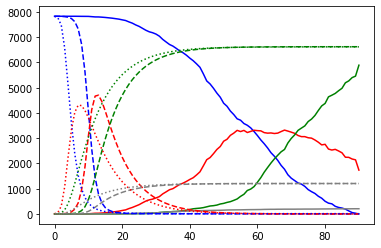

In [8]:
fit_params = Parameters()
fit_params.add('N', value=N,vary=False)
fit_params.add('beta', value=1, min=0, max=4.0)
fit_params.add('gamma', value=0.11, min=0, max=1.0)
fit_params.add('sigma', value=0.02, min=0, max=1.0)

N=fit_params['N'].value
print('N:',N)

#Test de f
x=np.linspace(1,92,91)
y0=[N-1,1,0,0]
y=f(fit_params,x,[N-a[0],1,0,0])
yf=fahd(fit_params,x,y0)
print(type(y),type(yf))
data=np.array([s[1:],a[1:],r[1:],d[1:]])
print(np.max(s))
print(np.max(data[0]))
## Plot real data
plt.plot(data[0],label="Sr", color='blue')
plt.plot(data[1],label="Ar", color='red')
plt.plot(data[2],label="Rr", color='green')
plt.plot(data[3],label="Dr", color='gray')

#Plot estimated data using odint
plt.plot(y[0], label="Sr",linestyle='dashed',color='blue')
plt.plot(y[1], label="Is",linestyle='dashed',color='red')
plt.plot(y[2],label="Rs",linestyle='dashed', color='green')
plt.plot(y[3],label="Ds",linestyle='dashed', color='gray')

#Plot estimated data using Mr karami's Algorithm
plt.plot(yf[0],linestyle='dotted', label="Sr",color='blue')
plt.plot(yf[1],linestyle='dotted', label="Is",color='red')
plt.plot(yf[2],linestyle='dotted',label="Rs", color='green')
plt.plot(yf[3],linestyle='dotted',label="Ds", color='gray')

#plt.legend()


In [9]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata, _ = data.shapedata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAX0AAAD4CAYAAAAAczaOAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nOydZ3hURReA30lCAgklCYTQe5dOqAJKC02qAqIiKKgofioWbKioFLGggEpTFKkqiiAoXQTpvbfQS4AAoYaQsuf7MTchgdTdJJsy7/Nc9u60e5bsnjt35hQlIhgMBoMhZ+DibAEMBoPBkHEYpW8wGAw5CKP0DQaDIQdhlL7BYDDkIIzSNxgMhhyEm7MFSIpChQpJmTJlnC2GwWAwZCm2bt16UUT8EqrL1Eq/TJkybNmyxdliGAwGQ5ZCKXUisTqzvGMwGAw5iBQpfaXUYKXUXqXUHqXUbKVUbqVUWaXURqXUYaXUz0opd6uth/U+yKovE2ect63yg0qptunzkQwGg8GQGMkqfaVUceAlIEBEqgOuwKPAaOBLEakIhAL9rS79gVARqQB8abVDKVXN6ncf0A74VinlmrYfx2AwGAxJkdLlHTcgj1LKDfAEgoGWwFyrfhrQ1TrvYr3Hqm+llFJW+RwRuS0ix4AgoIHjH8FgMBgMKSVZpS8iZ4DPgZNoZX8V2ApcEZEoq9lpoLh1Xhw4ZfWNstoXjFueQJ9YlFLPKqW2KKW2hISE2POZDAaDwZAIKVne8UHP0ssCxQAvoH0CTWMit6lE6hIrj18gMllEAkQkwM8vQYsjg8FgMNhJSpZ3WgPHRCRERCKB34EmgLe13ANQAjhrnZ8GSgJY9QWAy3HLE+hjMBgMhgwgJXb6J4FGSilP4BbQCtgC/AM8AswB+gLzrfYLrPfrrfqVIiJKqQXALKXUGPQTQ0VgUxp+lljOnIEhQ+DECXBzAxcXcHWFXLmgbl3InRuuXIEbNyBPHvD21u2SQyl9uLjow83tzhFTdveRKxf4+EDBgvrw8wMvLz2OwWAwZDTJqjoR2aiUmgtsA6KA7cBkYBEwRyk13Cr73uryPTBdKRWEnuE/ao2zVyn1C7DPGmeQiESn8ecB4OxZmDUr4bq//06PK6aO3Lm18i9Q4M7NwdVVv/fx0UehQrpNoULg7w/FikHx4rrO3DAMBoO9qMycRCUgIEDs9cjdvBlWrIDXX4eoKLh06c6sG+DoUTh4EEJC4PBh2L9fPyGsW6eV6syZULo0NG16Z0wRsNn0a1QUREfrIzJSl8W8F7nTNiICLl/W1794UR8hIfq4du1Ou6gouHpVt41pHxV17+fKk+fODaBYMS1jhQr6qFgRihbVNxGDwZBzUUptFZGABOuyq9KPy9Sp8PLLcOQIFC6cfHubTSvQo0dh2DB4//2Mn12L6JtASAicP69vSGfP6te45ydP6ptODHnyQPnyWv6aNaF+fX2k5HMbDIbsQVJKP1PH3kkrmjSBAQNS3t7FBXbvhhdf1Er/6lX44ouMVfxK6b0Gb2+twBMjOhpOnYKgIP3EEhSkj/37Yf58fQMD/URQrx4EBOibwAMP6Ccfg8GQs8gRM317sdng1Vdh7Fjo3x+mTMla6+k3bsC2bXqpa9Mm2LpVP+2AXgYaMACefRZKlHCunAaDIW3J8TP9GHbuhNBQePDBlLV3cYEvv9QbrHnyZC2FD5A3LzRvro8YQkNh9Wp9Axs+HEaMgA4doF8/eOgh8PBwmrgGgyEDyFEz/YAArbg3b06zIbM0x4/D5MkwbZreI/D1hSeegDfeMLN/gyErk9RMP0fZeUybBkuX2tdXRCvIyZPTViZnUqYMjBypN4MXL4a2bWHCBG0J9OqrehPZYDBkL3KU0r/vvjsmm6lFKViwAN59F8LC0lYuZ+PqqhX+rFlw6BA89pjexyhXTiv/mH0Ag8GQ9clRSh9g/Xro2dO+Wexbb2k7+6lT016uzEKZMvrz7d0LnTrB+PHaeuihh+Cff5wtncFgcJQcp/SvX4ft2+HChdT3bdpUm39+/nl82/jsSJUqeuZ/4gS8957eB2nZErp00aahBoMha5LjlH5goFZa991nX/+33tKK8Jdf0lauzEqxYvDhh/ozjxoFK1fq/7s33tD+CwaDIWuR45S+o3TsCI8/ruPh5CRy59Y3vEOHoE8f7axWsaI2/YxOlwhKBoMhPciRSv/NN/VhDy4uMGMGtG6dtjJlFYoWhe+/18s9lStr566AAB3ILhNb/xoMBoscqfSvXtWhlR3h1Ck4fTpt5MmK1KunnbzmzNEB4jp00LF+pk3TQeYMBkPmJEcq/YkTYdIk+/tHROiljbFj006mrIhS0KuX3iP58Udd1q+fjgD6+OPw009w7pwzJTQYDHeTI5W+o7i762Qs69c7W5LMgbs79O0Lu3bpZZ7AQFi2TJcVLQpt2sDcudnf4slgyArkSKV/8CA0bgz//mv/GI0awZYtZikjLkpBu3Y6F8G5czrA27Bh+v+7Rw8oWVJbAN2+7WxJDYacS0oSo1dWSu2Ic1xTSr2ilPJVSi1TSh22Xn2s9kopNU4pFaSU2qWUqhtnrL5W+8NKqb7p+cGSIiaAWkzYYXto3Fgrr507006u7ISLi34a+uADOHYMFi7U+wDvvAO1asGqVc6W0GDImSSr9EXkoIjUFpHaQD0gDJgHvAWsEJGKwArrPUB7dP7bisCzwAQApZQv8AHQEGgAfBBzo8hoihTR9uYtWtg/RuPG+tUs8SSPq6s2dV20SC//RETo//unnsp+IS0MhsxOapd3WgFHROQE0AWYZpVPA7pa512An0SzAfBWShUF2gLLROSyiIQCy4B2Dn8CJ1GihHbQeuQRZ0uStWjXDvbs0TP+adO01c/1686WymDIOaRW6T8KzLbO/UUkGMB6jUnIVxw4FafPaasssfJ4KKWeVUptUUptCUnHMI8ffqjX5R2hRw/tsWpIHZ6eOo7/zJnw3396ozc01NlSGQw5gxQrfaWUO9AZ+DW5pgmUSRLl8QtEJotIgIgE+Pn5pVS8VFOqlLYrd8Sh6Nw5+PZbHYTNkHp699ZWPdu367g+9sRDMhgMqSM1M/32wDYROW+9P28t22C9xvxkTwMl4/QrAZxNotwpPPWUjo3vSDasY8dg0CBYsybt5MppdO2qQ1YfPKg3ftetc7ZEBkP2JjVKvzd3lnYAFgAxFjh9gflxyp+0rHgaAVet5Z8lQKBSysfawA20ypyKIzP9unW1jbrZzHWMtm1h7Vod3+eBB2DMGBPSwWBIL1Kk9JVSnkAb4Pc4xZ8AbZRSh626T6zyv4CjQBAwBXgBQEQuAx8Dm63jI6vMKdy6pe3GP//c/jE8PKBOHaP004I6dbRdf6dO8Npr0L27Wec3GNKDFCVGF5EwoOBdZZfQ1jx3txVgUCLjTAUyRQqSPHmgc2eoWtWxcRo31mEdIiL0rN9gPwUKwG+/wVdf6YB4tWvr2D4x5rEGg8FxcqRHbgzffKMzQjlC48YQHg4HDqSNTDkdpWDwYG3V4+oKzZrBJ59AVJSzJTMYsgc5WumD4yEBHnpIL0PUrJk28hg0DRpoq57u3eHtt6FSJR0kLzzc2ZIZDFmbHK30J0zQNuOOZIDy9ARv77STyXCHAgXg559h/nzw84OBA3Wy9ilTzEavQSMiCR4xddG2aKJt0UTZomIPm+j4KzaxERkdec8Rtz4iOiL2uB11m9tRt2Pro23RsWXhUeGxR0x9lC0qXnlC9bcib91zxNSnFyla08+uBATo/K+OZn4aPRry5tXmm4a0RSm999Kpkw6d8eGHOnHL3Lk6mUuJEs6WMGXYxEZ4VDi53XKjUFy7fY1zN87hnduba7evcfzKcQ5fPkyVQlVwVa4UyVuEHed2UMizEMevHCfochBBl4MIKBZAPo98VC9cnXWn1uGT24cDFw8QFBrEmWtnqFOkDsXyFaN2kdpsOL0BVxdXDlw8wPErxwkND6VywcpU86tG1UJV2Xl+J1dvXyXochDB14MJiwyjRP4SNC7RmFIFSnHsyjEOXTrE2etnuRh2kShbFAU9C9K+Qnvyuucl9FYoa0+tJTQ8lKvhVxEEr1xe9K7em/CocFxdXPlt/29EREcQFhmGQuHu6s7zAc9z4uoJCnkW4ocdPyAiREZHggJX5cpbTd9i45mNVPStyMQtEwGIFv0jVShGthrJ/IPzCSgWwNebvr7n//rr9l8zYcsEWpVrxbiN4+6pn9p5Kh+t/ogulbswduO98dGnd5vOuyvfpVuVbgnWz+4+myHLh9CtSjfGbbp3/F96/MKrS16lW+VujN88/p76uT3m8sqSV+hcuTPfbv42wfrha4az/bntCXyTHCdHK/369fXhKAsX6gBjRumnH0pBq1Y6Zs/EiTpHb/XqMG6cTt/oiL9FQtyOus2pa6comrcoXu5enL1+lmVHltGqXCtclSshYSFM2TqFzpU7c/raabac3cKiw4toUaYFSik6VuzIoL8G0a9WP/4K+ovg68FcvHWR3G65ARgTOIYX/nqBHtV68Ou++P6Ovnl8eev+txiyfAidK3dmwcEFsXVz98+lVIFS9K3Vl+Grh/NQpYf498S/sTPRkLAQqvlVwyY25u6fS5OSTTh+5Tjnb57nWvg1iuUrRnhUOKeunWJvyF4qF6yMT24fLoVd4nb0bUp7l6ZI3iLciLjBlfArVC9cnWL5irHz/E7Co8JpWqop1fyqcfb6Wdxc3AgsH8ityFtsOrMJGzaalmxKg+IN2HNhD64urvSp2Qeb2FhzYg3ubu40KdGEJiWbYBMbPnl8eKnBSwCsOLaC/B75aVi8IU1LNeVK+BVKFSjFW011SK/FQYsp7FWYgGIBNCnZhBNXTlDJtxIfPPABCsWCQwsoXaA0tfxrUb94fbaf207VglX56MGPAPh9/+9ULlSZ6oWrU7tIbZqXbk51v+oMbzGcKFsU8w/Op7pfdSoXqsx9fvfRsmxLavnXYkTLEYRHhbPo0CJqF6lNBd8KVC5UmdblWhNQPICRLUdyI+IGS44sIaBYAGW8y1DeuzyB5QJpWKIhxfIX40r4FVYcXUGjEo0onr84pQuUJrBcIE1LNqVU/lJcDLvIqhOraFayGf55/SmZvyQtyjgQGCwZlGTi5+SAgADZsmVLul4jIkIfefPaP0afPtpB6/jxNBPLkAxBQdrB7r//dMKWCRMgX77E29+Ous2+kH2UyF8CPy8/zl4/y+frPufJWk9Sy78W/538j96/9WZQ/UH4eflRLF8xOs7qyHvN32P50eUcv3Kc4BvBsePNeXgOL/z1Ag9XfZgp26bElnvm8sQntw8zus9g9u7ZVPCtwLrT64iMjuRi2EXqFa1HQc+CPFHjCbYEb6GwV2HO3TjHzYibXL51mbpF61IgdwHK+5QnJCyEAh4FiJZoIqMjibJFUSxfMTzcPFAoBCGXSy5UWt/xDFkepdRWEQlIsC6nK30fH3jySceyYA0dqi1MwsPBLUc/O2Us0dEwcqSO2V+uYgSDvlxM24CKVPWryoWbF+gypwuvNnqVHvf1IOhyEBXHV+SVhq9Q2rs0dYvWpcPMDjwX8ByTtkziZuTNeGMvfWIpwTeCiYyOZPae2fjm8cXTzZMyPmXw9/Ln8ZqPk98jPyE3Q7gRcQPv3N7k98iPq4urc/4zDIY4JKX0c7yK+ugjx231S5fWCujMGX1uSB/OXDtDlC2K0t6libJF0WZGG7oHduefB/5H7yeEwRu70nzD+3z7bD+88+Uir3teTl87TfVvq3Pgorap/WrjV4BeN73xzg12nd9FtC2akvlLUrJASUrmL0nx/MUplq8Ybi7659G/bv9EZfLz8sPPK/1iRBkMaU2OV/r/+5/jY5Qpo58YLl40Sj8tmbNnDu6u7nSv2h2AOpPq0KlSJ77v8j1uLm7k98iPm4sbV/3/pOe3G5j2XwCr+Yrq333II/m+4O+XlhF88xSrTqzioUoPUaVQFSoVrERF34oU8iwEQE3/mnzV7itnfkyDIUPJ8cs7ERFw+bJOrGIvImm/kZgTGbdxHOdvnGdEqxEANPm+CV7uXizrswyAPw78gWcuTy6FXcLL3YvOlTsTFhlG/lH5UUpR078mJV0D2L2sDkeXtaJ2qYrMmuX4k5zBkNUwyztJ8OqrOq67I3FejMK3j++2fcfioMXM7TkXgL0X9nLq2p2UC/MfnY9vHl/WnVrHwkML+Tvob3ac2wFA2/Jt6Vy5M565PNn0zCaqFKqCZy5PAORpHc7h+ed1isZx46B/f/N3MhgghztnAfTqBZ995rizz4sv6s1cQ+IsP7qch2Y9xO0o7QYdFhlGaHho7PuJD03kr8f/IjI6kg2nN+Dn5Yeriysf/fsRn679lPwe+RnVahSbn9nMoscWxY5bt2jdWIUPWrk/8ojOX9ykCTzzjP47mwxdBoNZ3kkzGjXSZp/LlztbkszD+RvnmbJtCv1q96NE/hIsOrSIN5a9wYLeC6jgWyFeWxFhW/A2ftr5E7P2zOJS2CXOvnaWInmLcCz0GL55fCmQu0CqZbDZdCTVd96BGjW0T0Xxe/K1GQzZi6SWd3L8TD8yUtvX37jh2DilS8OJE2kiUpbmUtglzlw7A8DV21d5/5/3+e/kfwB0qNiBfYP23aPwt5zdQq2JtQiYEsDErRNpUaYF83rNwye3DwBlfcrapfBBO80NGaKVfVCQvjnv2uXABzQYsjg5Xulv3w5ly8I//zg2TpkycPKknlnmVG5H3abi+IqMWKM3YisVrMTZ187yaPVHAeI5ER0NPcr2YO1mXjxfcTxzeTKh4wTOvXaOX3r8QpcqXfBw80gz2dq1045cItC0KSxalHwfgyE7kuOVfqVKOoZLrVqOjVO6tLYEOncubeTKKvy691deX/o6AB5uHoxtN5bnA56PrS+SN75Z1N4Le+kzrw+VxlfizeVvAlA0X1E2DNjAwICB+OTxSTdZa9WCjRuhQgUdHfWdd0zIZkPOI6WZs7yVUnOVUgeUUvuVUo2VUr5KqWVKqcPWq4/VVimlximlgpRSu5RSdeOM09dqf1gp1TfxK2Yc3t7w9NM6UbojVKqkwytfu5Y2cmVmbkXeij3fc2EPy48ujy3rU6sPNfxr3NPn8KXD9Py1J9UnVOf3/b/zcsOX+bHrjxklcizFi+vUjAMGwKhR0Lo1BAcn389gyDYkFpr0rjCl04AB1rk74A18Crxllb0FjLbOOwB/AwpoBGy0yn3RaRR9AR/r3Cep69arV08yguPHRY4dy5BLZXk2nd4kBUcXlDUn1oiISHhkuNhstmT7fbHuC/Ea4SXvrnhXQm6GpLeYKWLaNJE8eUSKFhXZvdvZ0hgMaQewRRLRq8nO9JVS+YHmwPfWTSJCRK4AXaybQcxNoat13gX4ybr2BsBbKVUUaAssE5HLIhIKLAPa2XOjSmvattWbfYaEibJFxW7O3lf4PtpWaIt3bp1EwMPNI8GAX9G2aMZtHMdv+34DYFD9QQS9FMTwlsNjvWGdzZNP6uUepaB5c31uMGR3UrK8Uw4IAX5QSm1XSn2nlPIC/EUkGMB6LWy1Lw6citP/tFWWWHk8lFLPKqW2KKW2hISEpPoD2cOYMdpJy1E6d9bB17IbnWZ3ovOcztjEhmcuT2Z2n0n1wtUTbb/17FYafteQlxe/zIJDOiywh5vHPev7mYEaNfQGr4+PDt28YoWzJTIY0peUKH03oC4wQUTqADfRyzmJkZDfoyRRHr9AZLKIBIhIgJ9fxgSy6tBBm/I5ypkzsG2b4+NkBs7fOB+bgeiFgBcY2mwoKsE/4R0ioiN4a/lbNPiuAWeun2HOw3P4scuPGSCtY5QtqxV/2bL6u2AsewzZmZQo/dPAaRGJefidi74JnLeWbbBeL8RpXzJO/xLA2STKnc6FC7B+vePjlC6dPWLq7w/ZT6WvK/HDjh8A6FS5E92qdks2bvuSoCWMXjua/nX6s3/QfnpV75VlYr0XLQr//qtn/t27w+LFzpbIkJMZsXoEM3bNSJexk1X6InIOOKWUqmwVtQL2AQuAGAucvsB863wB8KRlxdMIuGot/ywBApVSPpalT6BV5nSmTNHu+o4m3Y5x0MrETs5JEpObs3Khyjxb91keKP1Asn1EhP0h+wF9c9j8zGYmd5ocu+aflfD1haVL4b77oGtXWLbM2RIZciLhUeGM+m9UrFNjWpNSO/3/ATOVUruA2sBI4BOgjVLqMNDGeg/wF9oyJwiYArwAICKXgY+BzdbxkVXmdHr21DM7VwfzX5QuDWFhOsRyVuOvw39Rd1JdQm+F4qJc+CzwM8r7lk+yz+2o2wxYMIC6k+tyNPQoAAHFEvT8zjL4+mplX6WK3qNx1GnPYEgtK4+t5GbkTbpU7pIu46coyqaI7AAS+jW3SqCtAAlmixWRqcDU1AiYEVSsqA9HqVkTOnaEW7eSb5vZKORZiLzuebkZeTNFDlJnr5+l+8/d2XhmI+81f48y3mXSX8gMomBBHUOpeXPo2xcOHwaPtHMONhiSZP6B+eR1z0vLsi3TZfwc75ELelln9Wo46+AOQ8uWOsaLo45eGcWJKyeYuWsmAA2KN2DNU2sokb9Esv22BW+j3uR67Lmwh996/sZHLT7CRWWvr1KhQjok86lTMHmys6Ux5BRsYmPBoQW0q9AuTcOQxCV7/VLtJCQEHnhAK+ycxPDVw3lp8UtcCb8CkOJN19m7Z+Pu6s6GARtis1plR1q1ggcfhBEj9LKdwZDebD6zmXM3zqXb0g4YpQ/orFnLluk1XEepWTNtbP7Tk4joCAC+bPcl6/uvT/Gma0yohdFtRrP5mc1J2upnB5SCjz+G8+fh66+dLY0hJzD/4HxclSsdKnZIt2sYpQ/kyqVjsDiSMjEuR46kzTjpwcg1I2k3ox2R0ZHkdc9LpYKVUtRv2o5pVPu2GqevncZFuVDYq3DynbIBTZvqCJ2jR+eMuEoG5zL/4Hyal26Obx7fdLuGUfoWmzfrQFyOUqxY5g7gVapAKUoVSN2mw+zds3lq/lNU8K0QG+M+JzF8uM6j/OWXzpbEkJ0JuhzEvpB96bq0A0bpxzJkCLyVlJ9xCilcWDt7ZSaibFGxtvRP1HyCH7v+SC7XXCnqO//AfPrM60Oz0s2Y/+h8vNy90lPUTEm9etCtG3zxhWO5lA2GpJh/QLs6dalilH6GMH68jqvvKP7+WulnJgetN5e9SaPvG3HuRuqC/a85sYaec3sSUCyAhb0XxstDm9MYNkzn2DVr+4b0Yv7B+dT0r5nu5s8pstPPCVRPoz3J++/Xa79RUXqvIDMwuPFgqhSqkuqAZzX8a9C3Vl9Gtx5NPo986SRd1qBmTejUCb76CgYP1vmQDYa0QET498S/rD21lnebvZvu1zOJ0S2OH9fxd7p3zx6OOCLCX4f/okPFDqmOf3Ph5gUKeBRINzvhrMqGDdC4sY7KOniws6UxZHVuR91m9p7ZjN04lh3ndlDIsxDr+6+/J4e0PZjE6Cngn3/gscccd9ACiI52fhq+Pw78wUOzH2LBwQWp6hcWGUb7me3p9nM3MvOEwBk0agQtWsDnn8Pt286WxpCVuRJ+hRbTWvDU/KeIjI5k8kOTOfHKiTRR+MlhlL5Fly6wbx+USN4hNUl27gR3d+c7enWt0pVfHvmFzpVT7nxgExtPznuS7cHbGVR/UJaJkJmRvPOOnhhMm5Z8W4MhIS7fukzrn1qz5ewWZnafye7nd/NMvWcybM/MKH0LX1+oWtXxdfiCBcFmc54Fz4bTGwi5GYJSih739UiV4h61ZhS/7f+NzwM/p2OljukoZdalVSuoX1/b7Tv7ac6Q9Qi5GUKLaS3Yc2EP83rN47Eaj2X45MoofYuICJgxQ8/UHaGw5bN0/rzjMqWW8Khwuv/cnf4L+qe675oTa3h/1fs8VuMxBjcyC9aJoZSe7R89qi2+DIaUsuzIMu6fej+HLx1mQe8FTptYGaVvoRT06QN//OHYOO7u4O3tnJl+brfc/PHoH4xrPy7Vfb1ze9OhYgcmdpxolnWSoXNnaN9eh9sYMSJzmecaMh8HLh7goVkPETgjkChbFIufWExg+UCnyWNMNi1y5YJDh3QGJUeJsdXPKGxiY3vwduoVq0eD4g1S1VdEUEpRw78Gf/b+M50kzF64uOjJQf/+OifyuXPalNPRfAyG7MfCQwvp9nM3PHN58mnrT3mp4UtOt4ozSj8OaRFTH2DgQL22n1FM3jqZFxa9wMYBG6lfvH6q+o7bOI6d53cyoeMEp38ZsxLu7noz19//jqfu9On6idFgALh++zoDFw6kaqGqLH9yeaaJV2WUfhyWLdMz9Mcfd2ycV15JG3lSSp+afRCRVGetOnTpEG8uf5PA8oG4u7qnk3TZFxcXbb7p7Q3vvafz6775prOlMmQWPlj1AWevn2Vuz7mZRuFDCtf0lVLHlVK7lVI7lFJbrDJfpdQypdRh69XHKldKqXFKqSCl1C6lVN044/S12h9WSvVN7HrO4ocf4IMPHB8nMjJjgq5dDb9KZHQkXu5ePF//+VStxdvExoAFA8iTKw+THppk1vEd4N13oVcvvcFr8uoaALYHb2fsxrE8W+9ZGpVo5Gxx4pGajdwWIlI7jpfXW8AKEakIrLDeA7QHKlrHs8AE0DcJ4AOgIdAA+CDmRpFZGD8etm1zfJyRI3W0zchIx8dKDBHhiXlP0GFWB7ucqCZtmcSak2sYEziGovnSYCMjB6OUjttUrRr07g0nTjhbIoMzibZFM3DRQArmKcioVqOcLc49OGK90wWIcVGZBnSNU/6TaDYA3kqpokBbYJmIXBaRUGAZ0M6B66c5BQtC/vyOjxNjtpneCdJ7V+9Nz2o9Uz1Lj4iOYMSaEbQu15p+tfulj3A5DC8v+P13bbvfvbtOwWnImXyz+Rs2ndnEmLZjUpRvOqNJ6Zq+AEuVUgJMEpHJgL+IBAOISLBSKmbRqjhwKk7f01ZZYuXxUEo9i35CoFQGJ5s9dAjmzYMBAxzbiPX316/nz6eNNVBCKKV4rMZjdvV1d3VnXf91seMY0oaKFfVmbufO8PbbJv5+TiM8Kpwhy4YwftN4AssH8ngNBzcH04mUzvTvF5F9gHwAACAASURBVJG66KWbQUqp5km0TUiLSBLl8QtEJotIgIgE+Pn5pVC8tOHgQR1T/+hRx8aJmemnh9mmiNBnXh/m7ptrV//g68GIiF3JVAzJ06kT/O9/2oTTrO/nHPaF7KPhdw0Zv2k8rzR8hQWPLsi0E6oUKX0ROWu9XgDmodfkz1vLNlivMSruNFAyTvcSwNkkyjMNgYFw44Z2s3eE9PTKvRJ+hUOXDqU6Nj7oqH73T72f5xY+l/aCGWIZPVqH9OjXT2fcMmRvZu2eRcDkAIKvB7PosUV82e7LTG3+nKzSV0p5KaXyxZwDgcAeYAEQY4HTF5hvnS8AnrSseBoBV61loCVAoFLKx9rADbTKMg0eHnpt1lGKF4dRo6B2bcfHuhufPD6sfXotL9R/IdV9x24cy7Erx+hRrUfaC2aIJU8eHdIjJASee8547GZXomxRvLbkNR7//XECigWwc+DOdE1onmaISJIHUA7YaR17gXet8oJoq53D1quvVa6Ab4AjwG4gIM5YTwNB1vFUcteuV6+eZCTR0SIjR4osW5ahl00xc3bPkRu3b9jV99z1c5JvZD55aNZDaSyVITE++UQERH74wdmSGNKac9fPSatprYRhyIuLXpSIqAhnixQPYIskptMTq8gMR0YrfRGRvHlF3njD8XFOnRI5etTxcWI4ePGgqGFKRq4eaVf/ZxY8I24fucmBkANpJ5QhSaKiRFq0EMmdW2TTJmdLY0gLrty6Iu+tfE+8RniJx8ce8sP2H5wtUoIkpfSNR+5dhIRA7tyOj9O1q17b/+uvZBpeuqR3/Hbt0u6cBQok2KxSwUqsfXottYrUSrUsNyNusvTIUl6s/yKVC1VOdX+Dfbi6wi+/6D2irl1h82btv2HIetyIuMGEzRP4ZO0nXL51mZ739eTjFh9TqWAlZ4uWaozSv4u0UPigzTaT3Mj97z947TWtCUSgZ89EI3bdirxFnlx5aFyysV2yeLl7sW/QPqJt0Xb1N9hPoUKwYIFOs9itG6xapdf8DVmDq+FX+XrT13y54Usu3bpEYPlARrUaRd2idZPvnEkxoZXvYu5c7VHrKIULJ6P0hw7VrpsffKCTr86alWC27fM3zlN2bFlm755tlxznbpwjIjoCz1yeOT65ubOoUUNv7G7apDd2DVmD3ed3U3ZsWYb+M5RGJRqx7ul1LHliSZZW+GCU/j0sX65j8DhK4cLaTj9Byw0RPd0bMEAr/YYN9Sx/3rx77jhRtigCywfa/UV7av5T3D/1fpPv1sl07ar/1NOnw+LFzpbGkBLeXvE2AFuf3crCxxba/aSd2TBK/y6+/RYOH3Z8HH9/nY3r6tUEKpWCv/+G4cPjl69YAe+/H0+A4vmL81O3n+xai19/aj2LgxbzSNVHMq2jSE7i7behfHm9qmdSLWZu1p9az6LDixhy/5AsP7O/G6P078Iljf5H2rXTszr3hCIW22wJdxo6VDsLvP8+ABM2T+DEFfujd33474cU8izEoAaD7B7DkHZ4eMBnn8G+ffDdd86WxpAU7696Hz9PP15s8KKzRUlzjNK/i337YNAgxyMlVqsGTzwBngkluG/TRqddupsiRXQw/jlzOLd+Ga8ufZWp26fadf31p9az5MgShjQZQl73e/cKDM6ha1d44AF9X0/wKdDgdP49/i/Ljy7n7aZvZ8vfjlH6d3HxIsyZA2fOODbO7duwdi2cvTvQxK1b2nLH1zfhjm+8AT4+FPlyCodePMRrTV6z6/ozd8/Ez9PPLs9dQ/qhFIwZo79nI0Y4WxrD3YgI7/3zHsXyFWNgwEBni5MuGKV/F82ba9P5Jk0cG+fyZWjaFObPv6ti/Xq92P/ggwl39PYmfNhQaN+ekgVKkt/DvljP49uPZ8OADXi5p0FcCUOaUrcu9O0LY8fCgQPOlsYQl2VHl7Hm5BrebfYueXJlT9tao/TTiZgAofdE2ly1Sm8cNG2aYD8RoYXXr7xWbI/d146MjkQpRTmfcnaPYUhfRoyAfPmgRQvYudPZ0hgAftn7Cz1/7UkZ7zL0r5PA8ms2wSj9BHj5ZZg5MwUNo6Nh4UI4d2/ESzc3HZP/Hlv9VaugXr1EPW8jbZG0KtuKOvkqJPCYkDzB14MpPqY4fxz4I9V9DRlHsWKwZo3+njRvDv/+62yJci43I27Sf35/es3tRVW/qqx8cmWmjpLpKEbpJ8CqVbB/fyKVItrcMjoaTp3SAdQXLkywqb9/AjP9Xr30TnEiuLu6M7zlcJ5YHKxdOO/ZFEiabzZ/w8Wwi9QoXCNV/QwZT9WqsG6djsratq323DVkLKG3QmnwXQN+2PED7zR9h9X9VlPWp6yzxUpfEgvKkxkOZwRcS5Z//tFx6qZPFwkPF1m/XiQ4OMGmDz4o0qxZyofefX63rD+1Xr85cEBfZ8yYFPe/GXFTCo4uKF3ndE35RQ1O5+JFkfr1Rby8RA4dcrY0OQebzSbdf+4ubh+5yeLDi50tTppCEgHXzEw/tTRrBr/9Bj16aMPrRo20qeXy5dClS7xs6CNGaLvsWPbsSTI2w8g1I+k4qyO3Im9B5cp6GShF60ya6Tunc+nWJQY3GmzPJzM4iYIFdX5dd3dt5hvnK2RIRyZumcjv+39nZMuRtK3Q1tniZBhG6SfADz/oCAkJ4uqqM1973LXmd/UqBAXFW99v0kRHWIjl+ed1AtVEmNxpMgt7L7xjNfD447B1q87jmAwiwlcbv6Je0Xo0K9Us2faGzEWJEjBpko7Pc7ejtiHt2XluJ4OXDKZ9hfZ2m0VnVYzST4AzZ2D37gQqnnsu8Zn3ww/Djh1Q8k5GyOPHdWjdyEj0Pxs3as+cRMjrnjd+fI9evbSlzz//JCuzUooZ3WYwtt1YE3Ihi9KjBzz5pFb669Y5W5rsy82Im/Sa2wvfPL782PVHXFTOUoMp/rRKKVel1Hal1ELrfVml1Eal1GGl1M9KKXer3MN6H2TVl4kzxttW+UGlVKZ9nho6VOvneNy8qW3rTp1KvGOuXBAWpuMviLB0qdbb586h+0VG6t27uzgaepTmPzRn74W98SuKFYPTp2FgypxE6hWrx/2l7k9RW0PmZPx4KFVKL/NcuuRsabInry19jUOXDjGj+wwKexV2tjgZTmpucS8DcW1aRgNfikhFIBSIMWztD4SKSAXgS6sdSqlqwKPAfUA74FulVMIB5DMjXl7aser115Nu9/PPerq2YUNsgvSQEPS0H6BMmXu6nLhygvM3z+OTx+fe8YoWTVa08zfO039+f45cPpJsW0PmJn9+HWX77FkIDIQrV5wtUfZiSdASJm2dxOtNXqdl2ZbOFscppEjpK6VKAB2B76z3CmgJzLWaTAO6WuddrPdY9a2s9l2AOSJyW0SOofPkNkiLD5HW7N2rLTFjnWZsNm2qqZQ2rE6Kxx7TYRYaN8bfXxedPw8cO6bfJKD0W5RtwYFBByiWL4G0Sjabfu7/+ONELzlt5zSm7phKlM2EbswONG6sN3Z374YOHeD6dWdLlD0IvRVK/wX9qeZXjY9afORscZxGSmf6XwFDgJjwkAWBKyISo2VOA8Wt8+LAKQCr/qrVPrY8gT6xKKWeVUptUUptCQkJScVHSTtE9KpK7I9t507w9oaVK5Pv7OEB9+sllpiZ/oULaEPsX3+Nt+YPcPraaWxiS3wd3sVFT/esJaN7ZRW+2/YdzUo1M6kQsxEdOuiHxk2b9AQkLMzZEmV9Xl78MudunOOnrj+R2y2NUuRlQZJV+kqph4ALIrI1bnECTSWZuqT63CkQmSwiASIS4BcTyyCDqV4dtm+PEynB01Nb0pQvn/JBvviCUsOeBiylX6IEPPJIvCcFEaHtjLb0/LVn0mM98oiOsb/n3tAMq0+s5vDlwwyom5i5kSGr0q2bvtevXg19+iSSkMeQIubtn8f0XdMZ2nwo9YrVc7Y4TiUlM/37gc5KqePAHPSyzleAt1IqRoOVAGJcR08DJQGs+gLA5bjlCfTJ3FSurLOrlC6d8j43buAWdpU1/0Tx5JNor93t2+M1sYmNoc2GJq+wu3bVS0u//XZP1Xfbv6OARwEeqfZIymUzZBl694bPP9fLPZ984mxpsibbg7fTb34/6haty7vN3nW2OM4nMa+thA7gQWChdf4r8Kh1PhF4wTofBEy0zh8FfrHO7wN2Ah5AWeAo4JrU9Zzpkdu7t8inn1pvQkNTP4DNFv998eIi/frZL9ADD4jcd989xW8ue1PeWf6O/eMaMj02m8hjj4koJfLXX86WJmtxIOSA+H3qJyXHlJQTV044W5wMgyQ8cpPZlUySN4E5SqnhwHbge6v8e2C6UioIPcN/1Lq57FVK/QLsA6KAQSIS7cD105WICMu+PjpaB0d55ZXUBUC31uhX/hzCrWuRdDx7Nt4m7okrJ1h6ZClP1HwiZSFcn39eBwSKioq3RPRJazP9y+4oBVOmaAODxx6DzZuhQgVnS5X5OXn1JG2mtwFg+ZPLKVWglJMlyiQkdjfIDEemiL1z65aOf7N6der7Xr4s4S555OeCz+s4OtOmxVaNWjNKXD90lVNXT9kt2tazWyXaFm13f0PW4uhREV9fkRIlRD7/XMfsMSTM4UuHpeK4ilJgVAHZHrzd2eJkOJjYOw6QOzcMHqxj7qQWHx9+bvQlG6OsxMpxZvpv3v8me1/YS4n8JVI+Xni4Tp4OHL50mHqT6zFxy8TUy2XIkpQtC4sW6a2l11/XD6D9+ll+IIZYZuyaQZ1JdbgYdpFFjy2idpHazhYpU2GUfiJ8+60VMeH4cYcMpQ888Bxh1y1L17J3QrYqpVJvYjlxIrRuDUeOMHvPbBSKLpW72C2bIevRqJF2A9m1C55+Wpt1tmiRZBy/HMONiBv0+6Mffeb1oU6ROuwcuNN4qCeAUfqJkDu39o6Up5+GVq3sHqdwYdhsq8OtAS/qsArAc38+x1cbvkr9YN26ASC//srsPbNpXro5xfPf4+pgyAHUqKEnJosWab+/Fi0SzOWTY4i2RdPt5278tPMn3m/+Piv7rqRkgZLJd8yBGKWfCE8/DX/+Ceqdd+CDD+wex98fmvEfHj9NgbNnibZFc/bGWS6F2RFYpXRpaNCAnUt/4sDFA/Su3ttuuQzZg5Yt4a+/4ORJnXb5zBlnS+QcPlj1AcuPLmdKpyl82OJD3FwcsVHJ3pj/meRo3dqh7h06QJthuZDK06FkSVyBP3v/GWMCm3p69mTuX6/jptyMbb4B0MuQixdD+/ZQrZregho8ONGMnNmOhYcWMmLNCPrX6U//utk3t21aYWb6iXD4MHSodpx13+7QZpt2UqAAFJowHNflSxARroZfBbA//PEjj/D+v/Cf14sU9Cxot1yG7EXTpjpkQ+vW8OGHevvo00+1hW925mjo0dg1/PHtxztbnCyBUfqJUKAA9I36jsb/C3AoldHt0DA4f54TthL893gzioz2Y82JNfYLVro07tt30fDVMfaPYciWVK2qnba3btVB2958E9q0geBgZ0uWPuy5sIdOszsBMLfn3JT5uxiM0k+MwoWh1/JnUQvm611dO3E7cwKAzaEVKWLz5BmPxtQtWtfu8UauGcnIK3/GOn8ZDHdTt67e4P3xR50Xok4dWLXK2VKlHRHREQxbNYy6k+py4eYF5vaYSzmfcs4WK8tglH5SlCoFHTs6NITrSR1S+aiUpeKcpYx761+83L3sGivKFsVXG75i57kd8MILMGGCQ7IZsjd9++olH29vbYA2daqzJXKczWc2U29yPT7890N63teT/YP206qc/dZ1ORGj9BMjNJRvHvyVPh0vOzaOlTxlvestDlw8oEMlHjpk11BrTqwhJCyEXtUf1cHbpkxxTDZDtqd6dR22oXVreOYZmDfP2RLZx+2o2wxdOZTG3zcm9FYoC3svZEb3GRTyLORs0bIcRuknxsaNDPq3J60KJ5QsNxUMHEjP+8/wb5EvaTO9DbYvx+jF19OnUz3U/IPzye2Wm7bl2+rEKtu362TshpzDyZPaVCc8PH55dLROrBuTrCcO+fLpKJ0NGsCAR2+w773Z8NlnMHs2rFmj+1y9mr6xm202bVv6/PN6spKK7//u87upP6U+I9aMoE+tPux5YQ8dKzn2BJ6jSSw+Q2Y4nBp75+ZNkW3b9KuDPPqoSJkaZ2T18dUix46JTJggcuNGqsaw2WxS+svS0mlWJ11w4oSO5zNypMPyGbIIixeLFCig/+4FCog8/bTIr7+KvPyySNGiutzdXeSDD0TCw+/0u3lTZO5cCe/SQ8JUHt0uocPFRaRgQZHHHxc5fDhtZL5+XWT8eJFKlfQ1PDzuXK9mTZGhQ/Xv7O6otBbB14PF/zN/KfJ5EVl4cGHayJQDIInYO05X7EkdmSLgmqN8/LHc/H52vN+gPVwNvyqP/PKIzNw1805h48b6h2PI3thsOuifi4v+e8+dK9K3r0jevHcUabduIjNm6BjMIFK5ssg334j06CHi6anLCheW630HSffCa6SC3xU5u3yvyJIlIlOn6ghu774r8tRTInnyiLi6ijzzjMiRI4kq5CQ5d07knXdEvL31tRs2FJk5U+T2bZE9e0RGjxZp3lx/JhApU0bk1VdFNm2KvV5UdJS0nNZS8gzPI3vO70nb/9NsjlH69rBwoWz5ZJn4+IhsdyRIX8GCMvy1+rLq2Ko7ZVFReoa2alXi/VLCDz+IDBwoDt9RDJmXq1dFnnxS/1S7ddMz5xhu3tTfoStX4vdZvFikbFndx99f5PnnRZYvF4mMFBGRfftE8ucXqVUr/nCxBAeL/O9/Irly3XmqaNhQPwH06iXStq1Io0Yibdrop4xJk0QWLRL5/nuRDz/U7Tw8dAKAhx8WWb8+8c934YLId9+JdOhw53rlyom8844M+/N1YRgyddtUx/8fcxhG6dtDw4Zyo0lreeEFB550r12T6+6I7/te0mDIMLlwwSqPihIpXVpnakkhJ6+ctFMIQ5Zl4UIdR9nFRS/ZRKcijHZYmMiOHfq7lgB//62H7dIliWGPHxcZN05k0CCRVq30bLxSJZH69UVatxYJCLjzFBH38PfXTwkHD6bu816+rJ86AgNlRXkXUR8gfT5tLLbUfG6DiBilbx+XLul1c0fYtUsEZN3rMwT3a7J5c5y6oKBEf5B3cyz0mDAM+W7rd/dW2mwiGzakeCxDFuDq1TvLNPfdp/++6cC4cfoSb77pwCDR0frmsHatXgpKg6fOo5ePiv8nhaTKG3nkujv6hrNvn8Pj5iSSUvopSYyeWym1SSm1Uym1Vyn1oVVeVim1USl1WCn1s1LK3Sr3sN4HWfVl4oz1tlV+UCnVNh32pdMOX19tp48DURgsc818VStCRD6dID2G8uXB1TVFw8w/MB+AB8o8cG/lH3/oeLurV9sppCFTERkJjzwCv/yiA/1t2wYNG6bLpV58EQYOhNGjYc4cOwdxcdGBAJs0gXLlwMPDIZlOXztNq59aEUE0c1/dSN6xE7SzQbVq2uvsk090CrGTJ+8c2T3WRFqT2N0g5gAUkNc6zwVsBBoBvxA/R+7z1vkLxM+R+7N1Xo34OXKPkFlz5J47J/LVVyInT0qNGnpJ1R4OTR4lDQcgC5cuFdBPrvFYtkykdm39WJsED/74oNz3zb35cUVEr+vmzastOQxZG5tN5LnnJOEvS/oQESFy//0iXl4ie/dmyCUT5dz1c1J5fGXJNzKfbDq96U5FcLDIF1/ofYWErI78/ESefVZk6VL9gQyOzfStMW5Yb3NZhwAtgblW+TSgq3XexXqPVd9K6ehiXYA5InJbRI4BQUCDVNyfMo5du3RO3GPH6NMH2rWzb5gLbZsRGVCXCvfpZCnxZvoAhQpBnjxJBkK/FHaJNSfW0LVK14QbeHrCww/D3Llw65Z9ghoyB2PGwKRJ8Pbb8NRTGXLJXLl0IhYvL/2AceNG8n3Sg8u3LhM4I5CTV0+y6LFF1C9e/05lkSLw6quwYYN+ep42Db7/Xh8TJ2p341mzIDAQ8uaFihV12TPPwJYtzvlAmZnE7gZxD8AV2AHcAEYDhYCgOPUlgT3W+R6gRJy6I1b7r4En4pR/DzySwLWeBbYAW0qVKpXud8QEsdlEQkLS1ComXz5tEZdapu2YJgxDNp/ZnHij5cv1jOeXX+wX0OBcZs7U1i49eqRuwzaNWLFCb+z27m2fhaYjRNuiJXB6oLh/7C5Lg5baN0hYmMi8eSJvvKEtjBo31iZKoB1ljhxJW6EzOaTVRi7gDfwDNEtA6e+2zvcmoPQLAt8koPQfTup6mcVO/+bN1P8QbkXekqg3XhP57DMRSWaf9eZNvRmWACE3Q2TWrlliS0qAqCiRYsVEevZMnZAG57N/v0j79vqn2LixVl5OYuRILcaXX2bsdUetGSUMQyZunpi2A1+9qmdaefJoc9AhQ5z6/5uRpJnS12PxAfAGcBFws8oaA0us8yVAY+vczWqngLeBt+OME9suscNpSn/GDJFp00REOxNCssvu9/Dl+i+l8JsucvGJh5NuaLNph5s2bewU1mL3bpFbtxwbw5BxREWJvPaaiJubtoP/4gvtuOREoqO1K4BS2o0kI1hzYo24fugqPX/tmfTExhHOnNFOZyBSsaLI6tXpc51MRFJKPyXWO35KKW/rPA/QGthvzfhjUjf1BeZb5wus91j1Ky0hFgCPWtY9ZYGKwKbkru8Upk6NDUnYpAmMGpX6SMa1Ctegz04oWKw8oJceX301gYZKwbBhMHToPVV7L+xl/MbxsYlXkqR6dYdCQBsymK+/hi++0KEwDx/WXw53d6eK5OICM2fqWPxPPJH+BmGXwi7R+7felPEuw5ROU+xPLJQcxYrp3/Py5do6qnlzeOmle+MX5RQSuxvInRl5TWA7sAu9Xv++VV4OrbSDgF8BD6s8t/U+yKovF2esd9HLPQeB9sld22kzfZst1bFx7uHcOT2zGD9eREQGDBApUiR1Q7y/8n1x+dBFLoVdSlmHGTO0Z2NGL8oaUsexY9pcJpP+rS5eFKlSRT+A7N6dftfpNqebuH/sLlvObEm/i9zN9eva2xi0k9nJ7On0iIPWO7tEpI6I1BSR6iLykVV+VEQaiEgFEekhIret8nDrfQWr/micsUaISHkRqSwifzt+y0onlNLmDBY3b8K1aynvfvDiQUKOWNE5S5QAdFKWkBAdbDBBLl3SM/44ljyLjyymYfGG+ObxTdmFb9/WkQzXrk25sIaMRUQbx4POh5AJk+EULKgDeXp66ry758+n/TVWn1jNvAPzGPbAMOoVq5f2F0iMvHlh3DgdY/rAAahXT2eYCQ+HnTv1o86//2acPE7AhFa+m+BgeP112LcP0H4f+fPD55+nfIhXlrxC07VPa6cVy8HL3187eYWGJtLp8mUYPhyWLgXgYthFNp/ZTLsKqbAX7dVLx9E1cfYzLzNnwpIles3Q+m5kRkqX1tm3Ll3SFsEREWk3tojw7sp3KZq3KC83ejntBk4NXbtqp6+CBbV5Z968ULu2XtcKDNRm29mVxB4BMsPhlOWd9etFcufWNmwWY8dqL/OUsiN4hyw+vDhe2ezZ+okySQeYM2diT2ftmiUMI76TSkoYOFDLn9qdZ0P6c+GCDl3cqFGWCZsxZ47+3g4cmHZj/n34b2EY8s2mb9JuUHu5elVHA33vPZGff9a/f39/Hf4iC1v6YGLvpBKbLc1tpVet0laVm1Kiw6OiZNg/w8T/M3+JtqVSjq1b4+0lGDIJwcEi9epp08E9WStM8Jtv6q/UpEmOj2Wz2aTupLpS5qsycjvKudZKibJ4sf7A//ufsyWxG6P0HeTmTZGjR1PW9qcdP8nWs1tF3n7bvtAIX30lUrWqSGSkhEXYOdN46SWRlSvt62tIew4c0BEqPT1F/vzT2dKkmqgokXbt9P0qqSjJKWHu3rnCMOTH7T+mjXDpxSuvaPW4aJGzJbGLpJS+0vWZk4CAANmS0W7U334LV67AO+/EFr3yCnz3HVy/nvS+W5QtCr/P/Oh1Xy8mfrZfb9ql1u5t0SIdRO2zz3RGa0PWZu1a6NwZ3Nxg4UKoXz/5PpmQ0FCoU0fHCNyxQ28dpZZoWzQ1JtQAYPfzu3F1SVnAQacQHq7zS547p82pO3SAChV0XWgobN2qDSfattV/20yGUmqriAQkVGc2cu9mwwZYuTJeUe/e2s4+ufujm4sbx14+xvsPvK9zgJYsGVsnAt27a4ONJOnYkc+fqkzgnz2JjI6080Ogr//zz/b3NzjO3r06cFPBgrB+fZZV+AA+PjBjhg5989JLqe9//MpxWv7Ukv0X9zO85fDMrfBB+7zMmQN+fvDyyzqeT6VKWvH7+kKbNvDQQ1ClijacuH3b2RKnGKP07+ann7QTRxwaNtSb+i4p+N/yzu1NMa8iWula5pqgnxC2b0+ZNeX8g/PxOn6WXNt2pFb6O4weDX36aGskQ8YTGqotRLy89CSiXDlnS+QwTZvqB+Aff4Rff01ZHxFh2o5p1JxQk+3B2/mxy490r9o9XeVMM6pV0zfuoCBt5lmpkn7cGTVKW9n99pu+Gz77rP77Tpyonb8yO4mt+2SGI7Os6UdG6mXZixcTb2Oz2WTgnwNl+ZHlIufP6/XAcePitWneXKRp06SvdS38mrh96CrnSxbUMW/t5fBh7U8/dKj9YxjsI+4ieGrMvrIAEREiDRqI+PiInDqVdNtoW7Q8/cfTwjCk+Q/N5VjosQyRMUOx2XSI9Pvvl9jcxL//7nSnOxxxzspRBAdrW/eNG+MVnz2rn+L++CPxriFhISw4tICgy0EQFqanRVWqxGtTujScOJG0CKtPrCZKojkx9kM9k7CXChWgUyc9+zAhlzOWd97R3k3ffKPjeGQjcuXSrgYREdCjR+KhmG1i47k/n2Pqjqm82+xdVj65kjLeZTJU1gxBKWjdGtasgfnz9fvu3aFnzyQ8MZ1MYneDzHBk+Ex/BJckhgAAIABJREFU924dkGn58njFEREi06cnb8Fjs9kkIirxJA5Dh+rwtUnleRi8eLB4fOxhv+VOXFat0rOPyZMdH8uQMqZNkzQ3bM+E/P67iKurSMuW95qz22w2eX7h88IwZOiKHPakGRmpk8ODyKhRThMDY7KZOZg1Syf/CQlJvM33276X15e8rt9cuCDStav9ZmM2m34Wf/tt+/obUsfy5TpqZsuWTo+YmRFMn65XEDt0uPNxbTabvPTXS8IwZMjSIekXOTMzY7PpmP4uLiL//OMUEYzSTwPOnBH577+E6y6FXZJaE2rdSQAxfLhI3bqOr+tFRIjUqSPyww+OjWFIf3bt0kk7qlcXuXLF2dJkGJMmaS3y8MN6K+P9le8Lw5BX/n4lZyr8GK5d0+v7/v4iZ89m+OWTUvqZz8DUmXzyiV50T8CuctQonaXt6tV7bfUv3LyAbx5fvHNbdvUHDuhYOqkMpnX2+lm8cnlRIHcBXZArl7YHdiQoV65c+vX4cShTxv5xDIlz5oy2486bVwe8K1DA2RJlGM8+q7ewBg+GwPfGsdLjI56u/TRj2o5Jv1DJWYF8+fSeXIMG0KWL9tXw9NTWXG3aONeaK7G7QWY4MnymP2SInrIkwN69ImvWpDA6wwMPJGimExmpHwC++irhbgPmD5CCowsmHHph9Wo9gD3MmqWnYymKAWFIMTabTlHp76+T02/f7myJnEbrV6cLw5B6n3aTyGg7v6fZkTlztCd23ETurq4iffuKHDqUbpfFWO+kkNGjdYLxBKhWTRvk3G2rH22L5nbUXY4ZdzlmxeDmBqdOadPfhFhxbAVNSzXFRd11kbVrdeKH6dNT+kni07Gjtif+6CP7+hvu5cwZbYffsycULw7//aejNOZAlgQt4Z8C/fAObcmuD2axZZNZQIilVy9t4nT7tvb0DwrS3m2//KKt+7p21T4A27frMLwZgFH6KcRmgxUr7o24uu7UOgp9Voj1p9brApF7HLPikpjZ5rHQYxy7coxWZVvdW9mkiV5b6t3bPuHz54fXXtNhALZutW8Mwx1CQrSCX7ZMh8vYuBFq1XK2VE7hwMUD9Jzbk+qFq7P9zT8oUSQ33brpn4DBQimdFa1AAShfHsaMgWPH9G9yxw7t8Vu3rs7wdfBguouTknSJJZVS/yil9iul9iqlXrbKfZVSy5RSh61XH6tcKaXGKaWClFK7lFJ144zV12p/WCnVN7FrOoUrV7RyXbgwwWqldFzxiRPjl/vm8eXxGo9Tza+aLggP13a6DRsmOE6pUnDy5L3lK46tAKBVuQSUvlLw5JOOpUP83//MbD+t+Ogj7XG7fr3OvZAJY69kBJdvXabT7E7kdsvNgt4LKFM0H3/+qSe2fftmXjP1TIG/P3z6qd5rO3FCRwK4fDk2TWu6kti6T8wBFAXqWuf5gENANeBT4C2r/C1gtHXeAfgbnQy9EbDRKvcFjlqvPta5T1LXztA1/VOntKnd4sWJNtm0STvbOsLgwSJ58txr2PPo3Eel6OdFk7Z42LJFpFkz+4X46CORfPkc/xA5mUOHtFlmNrfDT46IqAhpNa2VuH/sLmtPxvc6njxZL11/kwnC5Wcp2rYVKVcuTbx5SUuTTXQC9DboPLdF5c6N4aB1PgnoHaf9Qau+NzApTnm8dgkdmclkMyGu3Lpyr2t5Mn+wOXNEHnnkXoeWvRf2yl+H/kr6ggcOiJQvL7J5c+qFFdFmZEnFkjAkz8MP6/y2wcHOlsSpxNji/7D9h3vqbDaRwEC9f3nkSMbLlmWZMkWr5G3bHB4qKaWfqjV9pVQZoA6wEfAXkWDraSEYKGw1Kw6citPttFWWWPnd13hWKbVFKbUlJCQkNeKlO6dOweTJOsQywLwD8yg7tix7L8TZmf32W72McvFigmP06qWDVeXJE7+8ml812ldsn7QAlSvrNb+ABCOmJk++fDrio82mHyUNqWP9em2GN2QIFCnibGmcxtx9cxm3aRyvNHyFfrX73VOvlA5F7uYGTz1llnlSTNeuOnZ1IsYkaUWKlb5SKi/wG/CKiCSVJjwh41xJojx+gchkEQkQkQA/P7+Uiuc4n30GDzyQZPzknTvhuedgt5XzvEWZFnzd/us76/mgd7Bu3NDhV5Mg7mVWHF3B7N2zY56AksbVVe/yz5lj/25/p046cEpKrmfQiOj1+yJF4NVXnS2N0zhy+Qj9F/SnYfGGfNrm00TblSwJY8fqdBLjxmWggFmZQoXgwQf1rDAdf5spUvpKqVxohT9TRH63is8rpYpa9UWBC1b5aSCuvWIJ4GwS5ZmDAgW06V0SDiUPPqg33Rs10u9Le5dmUINB8Z1QTp/W4yQSh/nqVR2ie+zYO2XjN41n6D9DU+7MsnixtuRJKgJcUrRvr8P9JrJpbUiAefNg3Tq9iZs3r7OlcQq3o27Tc25PXP7f3nnHR1F1DfiZ3SSbXkhCSEJCDx1BkKIgSlEEBAtgF6yvHewo6hsVK4oiFhD47CCKoiAqIi/SRKQpRUqAJBDSe7LZZNv5/ribkJBKSzCZ5/cbsjN3ypnhzpl7zz33HM3A4nGLcTe617j/xImqffHEE7BmTT0J+W9n3DiIi4Pdu8/eNaqz+8hx27sGfAq8fcL2GVQcyH3d9XsUFQdy/5TjA7nxqEHcINfvZjVd+1y26R/MOig/x/1cOc/n4ME1hkR2OpWtc8oUtW532CXw1UC58/s7635xp1MNOJ/qgI/VqqaIx8ToYRrqQnGxGmDr2vXUJ8g1Ah5Y8YAQi3y397s6H5OTI9Kli0hAwL8uNXDDkJqqYvY899xpnYbTtOlfBNwCDNE07S/XMhJ4FRiuaVocamD3Vdf+P6I8cw4C84D7XB+XbOBFYItrecG17V/FDz/ARx/BJ39/wqiFoyiyFVXc4eBB5YtbDZpW0Vf/r9S/yC3O5dI2l9ZdCE1Tado0Dczmk78Jd3dlzjpwAObOPfnjmxqzZ8Phw8q/uom6Zy7du5R3t7zLlH5TGNtpbJ2PCwyEn35SEQhGjtRz+tRKWJiaiHk27frVfQ3OhaXeWvoOh2rJ1cHHbMIE1UA2W82yIfGECGxOp4po+fXXNZ5jxAgVjkFEZMbGGUIskpx/CkGZ/v5bpHnzGt1Mq8XpVC6qffs2eMKHc5r0dBVIbeTIhpakwTiSe0SCXg2S3nN7V+7Z1pHt25XTU69eIoWFZ1jAxsa77yovnj17TvkU6GEYaqG4GAYNqnYWbXnmzFHmNm93by6KvqhioabByy8ru1wNlJ+gtTt9Nx2DOxLuF37ycsfEwNChaibfyaJpKunpunWnF9CtsfPcc6o39eabDS1Jg+BwOrhl6S1YHVYWXbsID6PHKZ2nVy81PrljB8TGnlkZGx1XX63eydNJolQDTbOveiLe3irxZx0ICoL/xf+PPel7uLv33ZjcTMcL8/KUd00tA32XX66C7Tmd8PFVH5NbnHtqcnt6wsKFp3YsQLjrQ2M2q9ACehTOiuzerXx077+/Uha0psIrG15hbeJaPh77MR2CO5zWua64Au68E956S00w7979DAnZ2IiIUF4j6em17noqaHIOu+316dNHtm7d2tBiVCA/Hy6b+TAHTAvJnJpSMTjayy/DtGnKZdPHp/6EKi6GZ5+FIUPUm3UyiKjwEzYb/PFHk7VZVyIvT32dDxxQ3hTBwQ0tUb2z6egmBn00iOu6XcfnV39+RkIlZ2Wp72dMjMowWI2Tm47DoRqQp4imadtEpMoJPfojBzVQFxWlNHoteHjA9pff4hGPfypHw4yLU1/pOih8iwVmbfyAG765AbvTfqqSKzRNjZb98cepHfvwwyoQm+5QrUhLUy2tbdtg3rwmqfCtDit3LLuDlv4teX/k+2csNn5wsPIh+P135RChUw2nofBrQ2/WgUoifvnlasZqLXh6qhm5JlMViuDAAehQexf42DE1fND55W9xC0zDzXCa/w0mk4r0eKq9i/HjVdjmZ59VweKaspknPh4uuwySk2H5chgxoqElahBmbJzB3sy9/Hjjj8eT+pwhJk5UCv+JJ1R+kZCQM3p6nVrQW/qgTCLz59dpQHPO1jk8/r+HcEoVc8vj4lS/tRbCwsDgUUJcyUYubX0Srpo1Uarw4+LUbN2TQdPgvfdUX/vee5vuTN1t2+Cii5QN4tdfm6zCP5h9kBfXvcj4LuNrDw1yCmiailaSnw+3364sizr1h6704aSCg8TnxLPhwG4mTTRgsZQryM1Vg6F1aOm7uUFoz83YNcvJ+efXhf/+V5lrTtZ/PzpajUmYzWpMoqnx1VfKg8vdXXk0DRjQ0BI1CCLCfSvuw+Rm4u0Rb5+163TtCm+/rTpTN90E9tO0cOqcBNX5cp4LS7356UdFqZjHdWTZMqdERYns3VtuY16e8q/9++86nSP61ljhv5pkF2WfpLC1kJUlcuTIqR3rcKjs1k0Jh0PNfgQ1k7qJh53+YucXQizy7uZ36+V6b7yhHv2NNza9qnc2QffTr4XbblOtvFoQl9lj1CiNxMQTvPj8/ZVrX48edbpkC78QPA9PIMgr6FQkrp5mzY6nalyx4uSCshkMagApLU2ldCsuPrOynUuIqPhDgwapeDq33aZSozVvXvuxjZSUghSm/DyFvpF9uafPPfVyzUcfhVdeUZ7HkyY17ip3zlDd1+BcWM612Dt3L7tbJnw9oerCfftOaPrXzE8/ibzzTh0TrZ8Ka9eqJtSCBSd/7I8/qmMfeujMy3UusG6dipEEIpGRIvPnN/lZyXaHXYZ8MkS8pnvJnvRTnwl6qrz4ovrv6Natzp1lnRrgTCZRqc+lXpR+SUmdg2i9vO5lmbpqqoiIfPutyAUXiFgsrsIbbhBp3bpO58mx5IjNUQ+Bu7755tT7zA89pKrH99+fWZkakoQElcEGRMLDRWbPLvcf2LSZvna6EIss2H4KjYQzxIoVImFhIh4eIjNmnMUGURNAV/o18cUXIkajSoN3Evz4o8iwYSrLooiI9O6t0gXVgQdWPCDhb4TLwUP20wmvUXdyck4+G4/Fou7Jz0/kn3/Ojlz1RUGBstt7eqpclc8/L2I2N7RU5wzrE9eL8Xmj3LDkhprTddYD6ekiV12lNNOQIeXeL52TQlf6NbFjh8gzz9QaBSrHklP9C+F0qqBc999fp0t2nN1RRnw+Qjp3Fhk9+mQFPgXGjhWJiDj5Vu2RI6rpNXz42ZHrbFNUJDJzpkhoqKrq110nkpjY0FKdU2QVZUnUzChpN6ud5BXnNbQ4IqJep/nzVYC2oKBa4xfqVEFNSl+fnNWzp1pqYcyiMfiZ/Fhx44oK251OMGSkK6fjOvjoH8k7wv6s/dzd+27+vgB++UWNKZ7VmGdvvgkJCWpm2ckQFaVm+kZF1b7vuUR6uppsNnOmmmQ1bBi8+OLx7DdnCfWuKTRNw+l0YrfbMbpmV9rtdqxWKz4+PhgMBoqKirBYLJhMJjRNw2azYbVaCQkJwWAwkJOTg9lsxtvbG4PBQHFxMXa7ncjISDRNIzU1laKiIvz8/NA0ray8VatWaJpGUlISZrOZoKAgRISioiJEhLZt2wJw6NAhnvv1OSiED8d+SPrRdDINmWXlcXFx2Gw2AgMDASgsLMTd3Z02bdogIuzfvx+Hw1FWnp+fj5eXF61bt8bhcLB//36cTmdZeV5eHr6+vrRq1Qq73c6+ffsACAhQk79yc3MJDAwkKiqKW26xEhW1j3ffNfLII/58+y0MGZLDJZcE0759JCUlJezbtw93d3f8XJMqs7KyCAsLIzw8HIvFwr59+zCZTPi6YmFlZmbSsmVLmjdvTlFREfv27cPLywsf1xyXzMxMoqOjCQkJoaCggAMHDuDj44O3tzdOp5OsrCzatm1LUFAQubm5HDp0CF9fX7y8vMrK27dvT0BAAFlZWSQkJODn54enpyd2u52cnBw6duyIr68v6enpHD16FH9/f0wmEzabjdzcXDp37oy3tzdZWVkEn6WZ4LrSz8pSWbNqiTlzW8/bKkUYnDNHBWE8+uVBTFAnH/1Vh1YBcFm7y3DvA59+qvRSZKVswWeQdu2Ox/j/3/+gc+fjwdZqo1cv9ddqVZm6xo8/a18oEcFsNuPm5oanpyciwpEjRwgICCAwMBCHw8GuXbsIDw8nLCyMwsJCNmzYQHh4OEGBgZjXr2f79u30X76cdgcPcnDsWH4dOJCImBj8i4sxr1jBgQMHGD16NB06dGDTpk2sW7eO5s2b4+npicViISUlheuvv5527drx448/sm3bNvz9/XFzc6OkpITCwkImTpxIq1atWLRoEQcOHMDDQ9ULh8OBw+HgrrvuIiIiggULFpCcXDk53P33309ISAgfffQRmVXkUn744Yfx9/fnk08+IS8vr1L51KlTMZlMfPbZZxQVFVUqf+655wD47LPPsFqtFco0TSsr//yLz4mRGGKIYf3S9QC4ubkxbdo0ABZWEczPZDIxdepU7HY7ixcvrlTu4+PDY489RnFxMV9//XWl8sDAQCZPnkx+fj7fVBFFMjQ0lPvuu4/s7Gw2bVpK797Qu7cqO3YMXn89ErP5Th56KJWff66cOa5t27bccsstJCUlsWzZskrlnTt3ZsKECcTHx7N8+fJK5b169WLMmDHs37+fFStWVCofMGAAl112GTt37mRNFenAhgwZwqBBg9i2bRubNm2qVA7Qu3dvfv/9d/7+++9KZd7e3nTu3JktW7Yw4ixNDtSV/tChqiVbRQUoz229bqu0rVMnmDABzK26YPr+e+jbt9bLrTq8inDfcLqGdqXAFQ5p69azrPRLyc9XYZ+vuAK++OLkjp03Dx54AA4dgqeeqlAkImWxWY4dO4a7uzvNXa6PGzduJDg4mE4u/9bFixfTpk0b+vbtS3FxMbNnz6Zt27a0a9eOoqIiVq1aRd++fbniiiuIi4tj0aJF+Pj44O7uTklJCRaLhf79+3P55ZezY8cONm/eXFHOgABajx9Pu5tvJiE5mbSNG0nbsQOgTMZSRVhUVITD4SA/Px+r1YrT6cTDwwOTSUVO9fHxwc/Pj6CgILy9vbFareTm5pa1HKOiosjPzycsLAxPT09KSkoqlHft2hWTyURERAQmk4mioiLy8vLKWpa9e/cmMTGRyMhIPDw8KCgowGw24+nqkQ0YMIDk5GSioqIwGo0UFBRgsVhwczVQLr74YjIyMoiOjkbTNPLz8ykpKSl7FEOGDCEnJ4eoqCg0TSM3NxeHy4V35cGV/CQ/0S+0H/dceg+appGdnY2hXAS0yy67jOLiYiJdlTMrK6vsA2c0Grnsssuw2+20cCWJz8zMxMvLC1Afh+HDhyMiNG/eHE3TSE9PL2vV+/n5MXz4cDRNozQXdlpaWlnrNigoiGHDhuHm5kZISAgOB2zalEp2dhiLFsHKlc2ZOnUoF19sIjhY5aNOSUkpkzUyMpIhQ4bg7e1d1tNITk6mVatWALRq1YpLL70UX1/fMpmSkpJo3749AB06dOCSSy7B398ff39/nE4nycnJZfW4W7duruoWgJ+fHw6Hg5SUFLp0Ufmye/bsiaenJ0FBQfj4+GCz2UhLSyvrRfXr149mzZrRrFmzsrqVnp5OS1d49/PPP5+zhR5l87PPVEt/zJhqd9mctJnOoZ3xN/mf9uV+P/o7SflJTOg6gaIi5d7/1FPK+lAvbNqkWvquF6E2srKysNvthIWGwq23su7IETzGjqX/o48CMH/+fJo1a8Y111wDwKxZs4iMjGTcuHHk5eXxwQcf4OfnR3BwMAUFBaSnp3PeeecxevRo9u/fz5dVhIwYNWoUffr04dChQ/zyyy/4+vri6+uLu7s7IsKAAQMICQkh49gxjs2fj2nJEjwA99tvx+3aa2keEYGbm1uZIndzc8NoNJ6xoGH/dhJzEzn/w/OJ9Ivkjzv/wNvdu6FFOikSE1WI5l9/VYFlP/7432eBPNvUFGWzVqWvadr/AaOBdBHp5trWDFgMtAYSgAkikqOpt2oWMBIoAiaJyHbXMROBZ1ynnS4in9Qm+LkQWtnmsBE6I5RxXcYxf8z8KvfJ+HI1odFeKkTxSfLzzyqueL209MvjcMC0aWTffDOF/v5ER0cDsGrVKsxmM1dddRUAH3/8MSLCbbfdBjYbC594As/ERK6ZMIGiMWP45ptvsNlsiAi5ubkUFhZyySWXMHjwYFJSUvjwww/x9vbG19cXPz8/fH196du3LxEREZjNZpKTk/H29sbLywsvLy88PT3rppzXrYP//Af27VPdrbfeOrVkMk2MzUmbuf6b68m2ZLP1rq2nHSO/oRCBBQvgkUdU+2X16jpZV5sMp6v0LwYKgU/LKf3XgWwReVXTtKlAkIg86cqd+yBK6fcDZolIP9dHYivQBxBgG9BbRHJquvZZV/q5uSpkZsuW1dqpHU4HG49uJMgziO5hlbM+PPssvPmShdyRN+Hxw7c1Xu63hN9wipMhbYacEfHrit1uLzMJ/PXXXyQmJjK2c2fo25dvn3ySI15eTJkyBYA1a9ZQWFjIlVdeiYiwd+9esrKyyrqf6Wlp9Nyxg8E//UTRP/8w4733CAgIICgoiMDAQIKCgoiJiaFFixY4nc6ylvYZIztbhWdcsEBFA33//ZPPIdAEcYqTmZtm8tTqp4j0i2TxuMX0a9mvocU6bf7+G4YPVxPJV68Gl3WlyVOT0q/1bRSRdZqmtT5h81jgEtfvT4DfgCdd2z91uQz9oWlaoKZp4a59V4krEbqmaauAEcCik7yXM8vSpSrM3/791XreGA1GLm51cbWnGHWFk7BXn8bWtiO1JZJ7cd2LZBZl8vc9xwdwUlJUVrRx48BlGj0trFYrqampZXbcDRs2sG7dOp588skyu3B6ejoyZgzaP/8w0M0Nu90OJSVYnE4iIiLKWtoiwnfffYfNZsNgMBASEkJky5aEDhoEU6bgHRLC008/jbu7e5WyGAyGCjbiUyYjQ425fPcdrFqlwjI+8YQaRa/PZDX/QkSEDUc2MH39dH459AvXdL6G+VfOP/PhPxqI886DtWvV0Nzgwap61MEZr2lTnS9n+QVlxtldbj33hPIc198fgIHltq9Gte4fA54pt/1Z4LFqrnU3qlewNTo6+gx4rNZAXJxKhl7NrFWn0ymz/pglcVlx1Z8jIUH5gH/wQY2Xyi/OF48XPeTRlY9W2L5lizr8VH2Ri4qKZPfu3VJcXOw63xaJjY2V7GwVyC0+Pl7WrFkjJSVVJ7Q+cOCA/O+TTyQvOFi+nDBBYmNjZd68eWXle/fuleTkZLFVN2v5lVdUPImzgdks8uSTIm5u6iG1aiUyebLIzp1n53qNiGJbsczZMke6v99diEUCXw2U9/58r8EnX50t4uJEoqNFvL1FXntNxGptaIkaFurRT78qG4nUsL3yRpEPgQ9BmXfOnGhV0L69WqohPjeeyT9PxsPoQftm1ey3cSNW3FmeP5wrilS63ar44cAPWB1Wrup0VYXt3buraL5bt9aaTx0Am81GfHw8YWFhBAQEkJqaypIlS7jxxhvp0KEDMTEx+Pv7l3mItG7dmtblkqJkZGSQkJDABRdcAMCOHTs4duAA7aOjaTdyJP0vuYSIcrbxTjXlhnU64c8/VY8pI0NlvD5T+e9+/lnF9k9IUMHQHnxQNeH0wdhasTvtjP96PMsPLKdni57Mu3IeN3a/8V83YHsytG+vsnHdfz88+SR88gl88AFcXH0nvelS3ddApMaW/n4g3PU7HNjv+j0XuOHE/YAbgLnltlfYr7rlrM/IXbdOhSiogeT8ZMm15Fa/w913y2++owRURIfquPrLqyX8jXBxOCsHFOndW2To0OqPzc3NLWu55+bmSmxsrPz+++8iImK1WiUpKUnsNfRWUlJS5Ndff5XZs2dLbGysxMbGSn5+voiIFBYWVj72//5PzYevCzabyG23qZb4+PGnH94gKUnNnAWRTp1U4DidOuN0OuWuZXcJscisP2Y12pZ9TSxbpsJggcg11/z7o4icCpxuGIYqlP4MYKrr91TgddfvUcBPqJZ9f+BP1/ZmQDwQ5FrigWa1XfesKv20NHX7M2ee3nlKSsS55x9Ztar62GY2h01azmwpD6x4oMry//xHJCCgYqDHUkVst9vllVdekWXLlpWVJSYmVm9uOYFdu3ZJbGysPP/88/LJJ5/In3/+KXl5NUy3P3pUxaiZOrVO5xcRJfiMGSKaJtKv36kFebNaVXB1X191/eefF3GZrHTqTuyaWCEWeerXpxpalAbFbBaJjVXVyWAQuf121Z5oKpyW0kcNtqYANiAJuAMIRtnr41x/m7n21YD3gEPALqBPufPcDhx0LbfVdl0520rfYhFZuVIkPr7K4vTCdJm4dKLsTtt9Ri5ntVslx1J1r2LePKUvS0VZunSpfPzxx2Xl+/fvl8zMzFqv4XQ6JS4uThYtWiRbt24VEWXz//PPP8V8Mi3wnTuPx+k5dqzuBtLly9XNnCxxcSI9eqjqOGqUyKFDJ3+OJo7T6ZTZm2cLscjEpRObZAu/KtLTVX4kDw+RkBDVuW8K1KT09clZ1bDhyAbGLBrDr7f+yvnh1cyO+/57WL9ezazy8mL2bBWtwDVvqc4kJKSze/dfjBqlZihu374ds9nMwIED6+SzbrVay2an5uTk4OPjw+DBg8vs9qeMw6Hi1QQHKxv7ybBkico5+8ILatCiOn7+GW64QfncLVigMmXrnBQHsw9y/4/388uhXxjZYSTfXfcd7sYannkTZP9+VbUOHVJevnfd1dASnV1qctmsk3mnoZaz2tJfu1Zk27Yadym2FdfcYrrhBhWX3bXPhAmVo2YWlhRK1/e6ytK9Sytst9vtZSacnTt3yksvvSQZGRknfx8i8tlnn0lsbKwsWLBAdu3aVa19/5T49ltlJBVR91lXk8ujj6qWe79+VYetdjhEXn1VdXF69BA5fPjMydxEsNqtMn3tdDHovou5AAAc9UlEQVS9aBK/l/1k9ubZYnfoOQerIzdXZMQIVS3vvVdF3G6soIdWroILLlABu6ugqsHWSjidKuzwTTeVbapKH361+yshFlkTv6ZsW15ensycOVO2uT46drtddu60SP/+In/8Ufuli4uL5bfffpOioiIRUTb+xPoIGfzZZyJt29Y9PPFXX6nBCk9P5dpptYqkpipl366dqn4TJtQa1lqnMkl5STLw/wYKscj4r8bLsfxjDS3SvwK7XeSxx6QsadrnnzfOpGm60q+Kw4er9fd+4bcX5MIFF0qxrYZW7e7dUl06wrS042OZ478aL2EzwsRcZJYjroTlTqdTli9fLgkJCWXH5OUpH+P//Kf6S9psNtm4caO89tprEhsbK3/Xd165334Tufnm4ymN6qKsk5OPZ8UYMOC4z/2gQcrdqTG+cWeZVYdWSejroeLzko98sbMGlzGdatm4UXnNgciFF6psp42JmpS+btOvgk/++oTfj/7O3CvnVr/TO+/A5MkQH6/CAbhISFDRiP/7X7j7/iJCZ4Qy8byJDC4cTFJSElOmTCmLr34iEyeqSacpKZX9/Q8cOMDKlSvJzs6mXbt2DBkypII/fb1jsUDHjiry5hNPVCyz22H3bti8WcXIWbYMCgvVlOMbb4ToaLjmGj1K1kmyO303szfPZt72eXQO7cyS8UvoHNq5ocX61+J0qmBtTzyhYvmsWHHWUy7UG7pN/0R27VL9utPxKX/tNWUiOgGnU2TaNJG9e50y54c5Yoo1yerDqyU1NVWSavEZ++031fL47LPKZQsXLpR3331XDh48eOoyn0ny8pTdvtQdIj1dZM4c5Rjt7a1uBJTLxB13iKxerbo/BQUigYHK5DNtWq3zJJo6xbZi+XLXl3LxRxcLsYjndE+594d7pbBEN4mdKQ4eVNZGLy+RH35oaGnODOjmnRN44QU1gFiFeWJvxt4zMhiWkpIisbGxMnn+5Dqfz+lUle/SS0UcDods2LChbFKW2Ww+swO0Z4pjx0SmTFFvDIgEB6tRsi++UK6XVZlv4uPVIDioNJPPPiviuk8dZf7blrxNHljxgAS9GiTEIm1ntZUZG2dIprl2112dkyc1VeT881W67Pff//cnZa9J6TdN847NBocPK/NEOUrsJUTMjGBc53E1m3YcDuVieAL5+fkcPXqUrl27UlQETz2VxIUXRnLddXUPHfDpp1BQkIKb2zJSU1PLMvGcc6SlwWuvqbnuNhuMHAlt2sAbbygXzXfeUaGOa4ot8ddfyt31++9h1y4V57+aZ9uYcTgdbD62mbUJa/k96Xf+SPqDzKJMTEYTV3e+mtt73s6QNkMwGprWc6lvCgpUdf3lFzj/fJgxQ8Xr/zdyWlE2GyXu7pUUPoBBMzDvynlEB0TXfPzLL6vkK3/9VcH4vmbNGvbt20e7du14c/NbrN34CCEhdVf4TqeT1q03sHbtWry9vRk/fnxZJp5zhoICeP11lX+2pARuuQWeeeZ4OkZQhp2PP1aBhUqVfny8+iiUp2dPFWL06NHj9v0bblBjAg8+qMImnqlYPucQNoeN/Vn72Z6ynZWHVvLzwZ/JtmQD0DG4I6NjRjMwaiDXdL6m0UTD/Dfg56dSQi9aBE8/rSJ3jhgBo0ZBnz4qoqcrMdi/m+q6AOfCclbMOxaLmp+9Z8+pHZ+bq0wYw4eLiMjRo0fLwhoUFBRIdna2/BT3kxCLvP/H8dmpdXFSWbduncTGxspXXy2R2NiiOrlv1hs2m+r3Nm+uzDLXX1+1/30pDod6ViLKxVPTVETTmnA6RZ55RqRZM3WNtm2VKa4+3FHPIg6nQzYkbpBHfn5EzvvgPHF/wV2IRYhFQl8PlVuX3iqLdy/WTTfnEBaLGrZr0eL48JTRKDJpkogrbNU5DbpNvxy7dysF9NVXFTavT1wvb296W0rsVYcgLuPpp9Vj27ZNLBaLvPzyy/L999+XFTudTrlwwYUSNTOq7Fz79okMHFi17nI6nWUhEoqLi2XPnj2Sm6uiCLdufVxvNhgpKSIvvigSFaXu++KLRf788+TOkZsrMnv28TgTv/2m/OWq85Mzm9Vo9pAh6prPP6+2WyxqDOEcxu6wy9G8o7Ly4Ep58/c3ZeLSidLijRZCLOLxoocM/3S4PPHLE/L535/LztSddZsTotNgOJ0iR46ILF0q8sADKo5Phw4iO3Y0tGQ1oyv9EyksFHFNbCpl8k+TpeXMllJkLarmIFERm7y8JG3SpLJNhw4dKotlLyKy+vBqIRZ5d/O7Zdu2bBGJiancuTCbzfLll1/Ke++9J9YT4tv8/rtqWVx3XQO4sjudImvWqIlTpX71w4ap2DpnQphVq5SffumUyIUL1QSFqma3HT58POLnN9+oD/aAASLTp6s3r4H8/J1OpxzIPCDzts2Tm7+9WXrN6SUt3mghhucNZa14YpGwGWFy7eJrZeHOhZJXXEOgO51/Bb/9JhIRoWL5vP66SFZWQ0tUNTUp/aY1kFt6r1XEsxER0sxptPCtIX3Vc8+xe9kyvrn6aiZNmkSrVq0qFBfZihj00SBSClI4PPkwnm6eZWV2O7i5KRGWLYMuXQ6zfPl3mM1mhg4dyoABAyrF2Xn5ZZg2TYWkuf32U7/tOpORAQsXwpw5KvdsUJCKZf+f/1SbWeyM8MorypC6c6daf+MNyM9XcXvKk5ioRrqXL4ctW9S2iAgV46dFCzXGYDKdFRGtDit7M/ay/sh6tSSuJ6UwBYBQ71D6RPQhwi+CcN9wIvwi6BLaha7NuxLiHXJW5NFpODIy1GuxYoV6p4cNU2maL7pIDW2dC34Ip5UjtyE540p/6VLlVfLllxAWBqhBtUJrYY0DZiKCxWLB22TCtnkzW4C+fftWyv1qdVi5e/ndXN3pasZ2qjpw2OrVdoYNc2Ps2O8YPvwY11xzDeHh4VXu63DAZZep8eIjR85SZsD0dDWYumQJ/PabmrHSt69KYHLddfU3ciVy/GN8552QmalmqgHcequa0DV9ulo3m9WA8k8/waZNMHeuOnbSJJUo9cIL1dKvX51G3xxOB2nmNI7lHyO5IJnUwlTSzGmkFaaRkJfAgawDxOfE4xAHAC39WzIweiCDWw1mcKvBdArpVLdk7jqNBhHYvh2++kotCQlqu5cXdOumJnlddZVK4lKXFNHV6eFTrVe60i9l8WLlYvjrr2X/E+9veZ9n/vcMO/6zg1aBrao87NslS8hMTubOBx6oMueriFBkK8LHo3atbLc7mDz5V0aPNjBs2CWsWeNe5vFY1f9vVhbs2KFaEyJqYquf38nddiUcDpVMdN481e2w25U307hxMH68UpQNTfmPwO23q1nPzz2n1iMilJyzZqn1xYuVj93mzar5tWmT6hUA9Oihsme79iv282J7sJVN9gS2p+1ge8p24rLiyhR6eQI9A4kOiKZjcEdigmPoHNKZi6IvolVAq3NWyTudThwOBw6HoywxfelyYje/ujK73Y7NZsNut2O32yudp3Qpj4hUuG55vVL+WnXVNyfKeGLZiXLXdp6qluruv/w1yq9XdXzpX5vNicOhXi27Xf0trcLu7uDpqXoAVR1bnfxdu3ZlXF3S6VWBrvRrYGfaThbuWsgrQ1+p8CJbLBZMJhOGnBz23nMP5vR0ei9ditasWaVzvLXpLeZsm8O6SesI8w2rVJ6Zmcm6desYMWIE3t7eOByOslAMI0ZAcrLSS5qmrCpt24JHFVnWP/xQNXZfeOEkGuEicPCg+nLs3q2WP/+EY8cgJETFfpg0Cbp2/XekInQ64c03VXPqiiugqEh1gV54AZ59Vpl4hg6F227DFuhPUsZh9nvksd43m8dvX0Cg2Q5Angnim7uzbXAMhyeOJdIvkq5HLPi270JwdCdCfZrjYfSooEQdDgc2m61sKa80SsvLK8oTFUtV+9lsNqxWK1arFbvdXklx1qagyitbh6Pyh6shMBgMlT6KRqOxyu21nad0OfG48ttrOmdpeVXLiecvf64Tt1W1/UQZy2O3q3bH4cPq9bPboUsX1fn096/6uifeR2ho6Cm7bOtK32ZTrfsRI8oU277MfcQEx2DQKrfcMzMzmT9/Pld07855Dz6oFOS8ecrMUI74nHieWv0Ui/cs5trO1/LV+K8qnC87O5tNmzaxbds23N3dmTBhAu3K+7O7REtKUi7sTqcyTY8cqdzcQVkwzj9fWaO2blW2xN27ITBQ6eqJE5W7O3a7OtGhQ8dr2o4dyvadm6tOZjBAhw7Kf378eBVg/CzZwM80IkKOJYek7CRyzbmUWEsothVTaMnHEbefdGcRSZ5OJCWVO+esZln/1qxtH0RUVjHzZq/lvasv4Ej37vSJz+GyH9aQ3rIl7sUlHA0PJzcggMOtWzN59mwAbEYjeQEB5AUGsqNXL/Z0747Rbqd9XBxmX18KfXww+/piq+rLXAeMRiNubm64ubnh7u6Oh4cHHh4euLm5YTQayxRkeWVXnYLSNK3CMaW/y6+XHlP+fKXHVVVWKlepjOWvXZMiPhXF3hRIT1fjcx98oNTPvffC44+rDuvZ4pxS+pqmjQBmAUZgvoi8Wt2+Z0zpf/EF3HyzsvcOGcL+zP30nNuTFy55gccvehyAY8eOYTabiYmJQUT45dln6fX55zQvKVFjAeUiMdmddqb+OpXZf87GqBl5dMCjTLt4WtnArdPp5LPPPiMhIQFN0+jduzeDBw/G19e3RjHtdmWdCAtTl8vOVvlLXn/JxuM3JFEYl8INT7XmkpZxbD0QwJL93ejkdYRVza6jRcoO5jpuJ5A8YjhAe7dE/Lq1ggsuUEvv3qqp4elZowz1gdPpJDE3kX9S/yEjL4Pc/FwKCgsoNBdisViwFdtwWp0YHAbcHG64O93xcHrgxcmNL4hB8HI6aX0smcKoVtibNyckK4sLFy1i7403YunRgxb79tH7scfYOWMGBrudoM2bifzuO3J79sRgtVLQsyd+//xD6h13EPPggxXvw8uLvClTsHfpgrRqhf+bbyrbm58fWosWEByMXHophvbtMRQVoSUmYggMRPPzA1/fqrtzOo2WxER4/nnli+DmphK5TJmievZn+jt5zih9TdOMwAFgOCr14hZUgvR/qtr/tJR+Roay8Y4eDXY7+7/+gB3dQri++w2ICG/89AqDPM6jf0gkxMfzxe7d5Fqt3P/iiwBYJt1Eti2f5Mfv4ZinjaN5R0ktTOWloS8BcPWnV9PC2IIbO96I0WokNTUVu93OhAkTAPjxxx/x8/PjvB498DcYlHE+K0vJVboUFqrmfakhsKBAtcrz8iArC1t6DttTI2huPkwbEkgkmjEs43n+y1UeP7Eu8EoGpy/hy4tmM3ZgFn4znsXuPO464OenLB/ffKP0/vXXw549anygbVvIzxcOHRaefc5GcIiNRQuFPzdr9B+Yg7d3HsnJdhITTQwdfgyTp439e/05dNCX7j1TMXmWkJFhJOWoFx27xOMQC8nJ3qSk+tIyOgGjm5W8bB9yc/xpGXUEI0JBrh8FeQFEhqdgNEBBgS8FBX6Eh6egaVBQ4IPZ7ENIeDJ2g518ixdFVi9CWqZj8jThtIXipgXTpq0Nk5uJogI/xO5D1xhPQnxDMBf44HR60qmTJ15eXmRmGiguVmPAoFpcViu0bHl83W6xEaGlQGgo6QVeEB9P8/XfwM03k25ogdum9TR761n44APSj9kwff8VAe++BI89RrrZB0+TE/+3X4QVK0h7cDreqYfwK0oHII3m+Nx6Lb4/fg1z55J67X34UoAvRarcGIHPw3fjm7QPJk0i9eHX8LXl4FuSBd26kUI4fmMvxbc4CwYMIGX+CvwKkvG15cD555NSHIR//y74uJUgLaNIXb0Hv8JkfLUipHMXUgt98e8ciY+34PT2Je3vVPxtWfiY7DgiokjPM+HfKhAfPyMOMZCeUESAexHevgbsXn5k5LgREOGDt4+G3SZkpDkJDBC8fI3YnEYysw0EhRjx9FQ91qws1QP19FTPOTtbOYCZTMrqlpMDzZqpb92J68XFquoHBysb+InrFot6LUJClMIsKlIOXqGhylZ+4nrpWH/z5qqDe+J6YaFawsJw1T21TwuX896J6/n5SgaX/0el9bw8dU/Nm6v13Fz1TEJDK68fPgyxscpRzuFQ23r0UMugQapn7++vnt2pci4p/QFArIhc7lp/CkBEXqlq/1NV+ht++oJl38zFFnkeJrMZq7c3x7R02mrtKDInYvRqhmexFQ/vCPKcWQAYNCNOBEOJGfHwJFlLJ8LQEgMGjBgxYMAgBgqdObjjjknzxsNwvNXsFCcOsVEs5gqy1PXpujrdqsuOpraUfv3LNwM0VaahYbd6kJHegsCgLLx8zGRnBLN108WEhKZjs3mQnhZGdlYoI8d8S0BgLnPfeRSLxZvjJwaDwcHtt/8fvr6FvP32w1XKdt997wPC++/fX2X5pCn/Ja/Ah6ULnqiyfNzTd5GR3Jq1H087oUQAjd+3b2H39lbcc3coTid4eCj5SsPwlJSoF+TWW9W20sgXVqv6sGVnK+vbffep8lIvp+JiCA9Xnk9vvaVC6DqdqpENSlHExKgP4fTpqhUmcry8sFB9LDdtgqeeUrFYNA38fRwIGgVmA1cPyuSr6Qd45IvevDPXRDdtD8Pd1/Cdx3UcMwfyRL+1xJ63lMdSH+PDpSHcpn3M/bzH1+43MtP2EG/3WMAt5rk8G7GAd9d2410e5Dq+ZJexJ5c4VvNt52kMTfyIN9rP4b87r+FnRjCIDQC4Y2Vj5zvpm72SWd5TmRI/he30pBd/U4wJL4rZ1WUC3Yq38ab5Hh5Le5z9xBBDHBmE0JwMDncZTRuPY7weP44n86ZxhCiiSOIwbWjHYZI7XUp4qINXtgzl6eL/kk4IoWTxNz3oyd9kdehPYEwor6zszTP2WLIJwp881nExQ/iNvPa98bygOy9/3Z7n7c+Qhz+eFLOcKxnHNxS264FcOpRXPgrjZcdUCvFBQ1jIjdzFfIpbd6Rg5PW8MdeX1xyPU4QXNtyZz108ypvYWrYmZdyDvPWOkXecD2DGB7PmwztM5nV5nILorhwaN5XZb9v51HkzGYSSrwXwKk/ysUwio20//rr6BebMNPODjCSBNmRrwTwnz7NGG8qBdlew/qo3WPBGLn/Rgz/pR6YWyhPyOoc9OvJ765tYecXb/N+sAjII4WdGkK6F8YDMxukbwLLIe1l6ySzmz7XjRRELuZlULZw7ZB7hgRZmmZ5gmt877DlooiP7mc2DJBHJfXxAt0cu5803q3ylauVcir0TCRwtt54E9Cu/g6ZpdwN3A0RH1xIDpxp8/ALJ8/FEHHlYjMW4lRTTzGiixJiHEQeImQJnHlht2DU7Ts2A02hANA1vdztu4sAXDyzOQtww4IbRtRgwiBkHQomYsYoRJw4EJ4KTUl3NcbWt/jUawGCs/NdgKNO/pR+H0vTyUuFzUc2nQ7MREnYIg2bAqWkEBWcyvPO35crL/9SY/NZ0jAYj4nDDbvfAbvXAw2THy9eK3eHGHc9+itVmws3DgNFowuHwJKiFhfY93Cm2uHOjzwYsBT74BdkwagasRSYioosZMLwfTnMQof6pWPJ8aBXljqeHO7k5Rjp1gltvnceRI/COv/LELO3OZmZqdO8O/c67AH8PuOMOVd6xo1K+6elK6YLadtNNqsVUOmUgJUWF5wFluRo3Tinq0vKkJDXWC6oVddVV6kPQvr3advTo8dBAvXqpTqHDoeQDFS5o0iT1u0+f4x5WrVsby8pvvy8ELgyhTwJcngDu7l0pie7KFaju/MAHh8GwYXT9CC40wxGvB3k3SpmJLj4K0VMehcGPEvEBXOAB3/p9zubIzxGBYcng/dBM6PUyxgX+9P8B/s/nO1YH5pLn25Jrkx14TIyFNg9j/7YNo1ems8zjdXaZUkgK6s5dufG43fQwhOejLWvP9ev3sE57kHj3VA4168MUy1a06++FMAvGpW25bdtGtjmu56h7Dgea9eNJ2xqYcCe0AI+ACO75ZyW7baMI8LCwL6Afzxh+wjlmIrT0xqsomAcOLeOgdSCeJiHdvz/PmVbgHDYBaRtOsyMmpiR8zRHr+Rg8Tdh9uvO8/wpkwJVoXboQ8beVR44tIqW4C3bvAPy8WvBi6I9ItxEYu3ehdbccHkv7nExLe4r8mhPu4cn0yJ9xth6KqVNbOnY6wqOZn5FT3Io8v5a0d7cR23oNRF6MV0wUPdrv4aHcReRaoskJaE0PYy7T2m9CWlyIf4cwLmi9mciCb8gvaUlOQDv6acn07LILgvsS3CGYgVF/0a0ohYKSCPICYxjMQS7r5QE+5xPWMZChkVsoLnZSWBJOfrNOjHDsIqR/B3DrSWRnf0ZG/A+PknwKS8LID+7CGNtW2g2OIsjZkxv6+LNj5hoCS1IpsISR7tWF/vY9BEVdXvV7f5rUd0t/PHC5iNzpWr8F6CsiD1a1f0MmRtfR0dH5t1JTS7++QxgmAeXTJbUEkutZBh0dHZ0mS30r/S1AB03T2mia5gFcDyyrZxl0dHR0miz1atMXEbumaQ8AK1Eum/8nInvqUwYdHR2dpky9J1ERkR+BH+v7ujo6Ojo69W/e0dHR0dFpQHSlr6Ojo9OE0JW+jo6OThNCV/o6Ojo6TYhzOsqmpmkZQOJpnCIEyDxD4vzb0Z9FRfTncRz9WVSkMTyPViISWlXBOa30TxdN07ZWNyutqaE/i4roz+M4+rOoSGN/Hrp5R0dHR6cJoSt9HR0dnSZEY1f6Hza0AOcQ+rOoiP48jqM/i4o06ufRqG36Ojo6OjoVaewtfR0dHR2dcuhKX0dHR6cJ0SiVvqZpIzRN269p2kFN06Y2tDz1jaZpUZqmrdE0ba+maXs0TZvs2t5M07RVmqbFuf6eRhbOfxeaphk1TduhadoPrvU2mqZtdj2Lxa5Q300CTdMCNU1bomnaPlcdGdBU64amaQ+73pHdmqYt0jTNs7HXjUan9F3J198DrgC6ADdomtalYaWqd+zAoyLSGegP3O96BlOB1SLSAVjtWm8qTAb2llt/DXjL9SxygDsaRKqGYRbws4h0As5DPZcmVzc0TYsEHgL6iEg3VLj362nkdaPRKX2gL3BQRA6LiBX4EhjbwDLVKyKSIiLbXb8LUC91JOo5fOLa7RPgqoaRsH7RNK0lMAqY71rXgCHAEtcuTelZ+AMXAwsARMQqIrk00bqBCi/vpWmaG+ANpNDI60ZjVPpVJV+PbCBZGhxN01oDvYDNQJiIpID6MADNG06yeuVt4AnA6VoPBnJFxO5ab0p1pC2QAXzkMnfN1zTNhyZYN0TkGPAGcASl7POAbTTyutEYlb5WxbYm6ZeqaZov8A0wRUTyG1qehkDTtNFAuohsK7+5il2bSh1xA84HPhCRXoCZJmDKqQrXuMVYoA0QAfigzMIn0qjqRmNU+nrydUDTNHeUwv9CRL51bU7TNC3cVR4OpDeUfPXIRcAYTdMSUKa+IaiWf6CrSw9Nq44kAUkistm1vgT1EWiKdWMYEC8iGSJiA74FLqSR143GqPSbfPJ1l816AbBXRGaWK1oGTHT9ngh8X9+y1Tci8pSItBSR1qi68D8RuQlYA4xz7dYkngWAiKQCRzVN6+jaNBT4hyZYN1Bmnf6apnm73pnSZ9Go60ajnJGradpIVGuuNPn6Sw0sUr2iadpAYD2wi+N27KdRdv2vgGhUhR8vItkNImQDoGnaJcBjIjJa07S2qJZ/M2AHcLOIlDSkfPWFpmk9UYPaHsBh4DZUA7DJ1Q1N054HrkN5vO0A7kTZ8Btt3WiUSl9HR0dHp2oao3lHR0dHR6cadKWvo6Oj04TQlb6Ojo5OE0JX+jo6OjpNCF3p6+jo6DQhdKWvo6Oj04TQlb6Ojo5OE+L/AXqQ1N0UkeIFAAAAAElFTkSuQmCC
    resid = 0.0*data[:]
    ret=f(params,x,y0)
    for i in range(ndata):
        resid[i, :] = data[i, :] - ret[i,:]
    #resid=data[0, :] - ret[0,:]
    return resid.flatten()

[[Variables]]
    N:      7833 (fixed)
    beta:   0.20453031 +/- 0.00100410 (0.49%) (init = 1)
    gamma:  0.03832891 +/- 8.1646e-04 (2.13%) (init = 0.11)
    sigma:  0.00303510 +/- 5.0970e-04 (16.79%) (init = 0.02)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.503
    C(beta, sigma)  =  0.496
    C(gamma, sigma) = -0.117
[[Variables]]
    N:      7833 (fixed)
    beta:   0.19283984 +/- 8.6675e-04 (0.45%) (init = 1)
    gamma:  0.03719111 +/- 7.0643e-04 (1.90%) (init = 0.11)
    sigma:  0.00256432 +/- 4.4299e-04 (17.28%) (init = 0.02)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.530
    C(beta, sigma)  =  0.500
    C(gamma, sigma) = -0.136


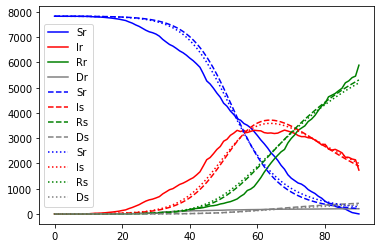

In [10]:
y0=[N-1,1,0,0]
out = minimize(objective, fit_params,  args=(f,x,data,y0))
outf = minimize(objective, fit_params,  args=(fahd,x,data,y0))

report_fit(out.params)
report_fit(outf.params)
y=f(out.params,x,[N-1,1,0,0])
yf=fahd(outf.params,x,[N-1,1,0,0])

## Plot real data
plt.plot(data[0],label="Sr", color='blue')
plt.plot(data[1],label="Ir", color='red')
plt.plot(data[2],label="Rr", color='green')
plt.plot(data[3],label="Dr", color='gray')

#Plot estimated data using odint
plt.plot(y[0], label="Sr",linestyle='dashed',color='blue')
plt.plot(y[1], label="Is",linestyle='dashed',color='red')
plt.plot(y[2],label="Rs",linestyle='dashed', color='green')
plt.plot(y[3],label="Ds",linestyle='dashed', color='gray')

#Plot estimated data using Mr karami's Algorithm
plt.plot(yf[0],linestyle='dotted', label="Sr",color='blue')
plt.plot(yf[1],linestyle='dotted', label="Is",color='red')
plt.plot(yf[2],linestyle='dotted',label="Rs", color='green')
plt.plot(yf[3],linestyle='dotted',label="Ds", color='gray')


plt.legend()
